# Shape Analysis of Cancer Cells

Lead author: Nina Miolane.

This notebook studies *Osteosarcoma* (bone cancer) cells and the impact of drug mutation on their *morphological shapes*, by analyzing cell images obtained from fluorescence microscopy. 

This analysis relies on the *elastic metric between discrete curves* from Geomstats. We will study to which extent this metric can detect how the cell shape is associated with the response to mutation.

This notebook is adapted from Florent Michel's submission to the [ICLR 2021 Computational Geometry and Topology challenge](https://github.com/geomstats/challenge-iclr-2021).

<center>
    <img src="figures/cells_image.png" width=600px />
</center>

Figure 1: Representative images of the cell surfaces using fluorescence microscopy, studied in this notebook (Image credit : Ashok Prasad). The cells nuclei (blue), the actin cytoskeleton (green) and the lipid membrane (red) of each cell are stained and colored. We only focus on the cell shape in our analysis.

# 1. Introduction and Motivation

Biological cells adopt a variety of shapes, determined by multiple processes and biophysical forces under the control of the cell. These shapes can be studied with different quantitative measures that reflect the cellular morphology [(MGCKCKDDRTWSBCC2018)](#References). With the emergence of large-scale biological cell image data, morphological studies have many applications. For example, measures of irregularity and spreading of cells allow accurate classification and discrimination between cancer cell surfaces treated with different drugs [(AXCFP2019)](#References).

As metrics defined on the shape space of curves, the *elastic metrics* [(SKJJ2010)](#References) implemented in Geomstats are a potential tool for analyzing and comparing biological cell shapes. Their associated geodesics and geodesic distances provide a natural framework for optimally matching, deforming, and comparing cell shapes.

In [2]:
import matplotlib.pyplot as plt
import os
import geomstats.backend as gs

gs.random.seed(2021)

# 2. Dataset Description

Normal and Transformed Retinal Epithelial Cell Lines
    The human retinal pigment epithelial cell line, ARPE-19 was transformed into three cancer cell surfaces, with each cell surface transfected by a different driver oncogene. These mutated genes are AKT, MEK and RAS, and will be referred to as the AKT, MEK and RAS surfaces respectively. These cells were cultured either on plain glass substrates (GDA) or on glass slides coated with Fibronectin (FN) and imaged as described previously \cite{alizadeh2020}

In [3]:
base_path = "/home/wanxinli/dyn/dyn/"
data_path = os.path.join(base_path, "datasets")

dataset_name = 'retinal'
figs_dir = os.path.join("/home/wanxinli/dyn/dyn/saved_figs", dataset_name)
print(f"Will save figs to {figs_dir}")


Will save figs to /home/wanxinli/dyn/dyn/saved_figs/retinal


In [4]:

def load_mutated_retinal_cells(
    n_cells=-1, n_sampling_points=10, quotient=["scaling", "rotation"]
):
    """Load dataset of mutated retinal cells.

    The cells are grouped by mutation in the dataset :
    - the *control* cells are ARPE19,
    - the cells treated with Akt mutation,
    - and the ones treated with Mek mutation
    - and the cells treated with the Ras mutation.

    Additionally, in each of these classes, the cells are cultured on two surfaces :
    - the *GDA* cells (simple glass)
    - the *FN* ones (Fibronectin coated glass).

    Parameters
    ----------
    n_sampling_points : int
        Number of points used to interpolate each cell boundary.
        Optional, Default: 0.
        If equal to 0, then no interpolation is performed.

    Returns
    -------
    cells : array of n_cells planar discrete curves
        Each curve represents the boundary of a cell in counterclockwise order.
        Their barycenters are fixed at 0 (translation has been removed).
        Their lengths are not necessarily equal (scaling has not been removed).
    cell_shapes : array of n_cells planar discrete curves shapes
        Each curve represents the boundary of a cell in counterclockwise order.
        Their barycenters are fixed at 0 (translation has been removed).
        Their lengths are fixed at 1 (scaling has been removed).
        They are aligned in rotation to the first cell (rotation has been removed).
    surfaces : list of n_cells strings
        List of the surfaces whre each cell has been cultivated.
    mutations : list of n_cells strings
        List of the mutations given to each cell .
    """
    cells = (
        open(os.path.join(os.getcwd(), "dyn/datasets/mutated_retinal_cells/cells.txt"), "r").read().split("\n\n")
    )
    surfaces = (
        open(os.path.join(os.getcwd(), "dyn/datasets/mutated_retinal_cells/surfaces.txt"), "r").read().split("\n")
    )
    mutations = (
        open(os.path.join(os.getcwd(), "dyn/datasets/mutated_retinal_cells/mutations.txt"), "r").read().split("\n")
    )

    cells = cells[:-1]  # the last surface is blank, and cannot be removed
    for i, cell in enumerate(cells):
        cell = cell.split("\n")
        curve = []
        for point in cell:
            coords = [int(coord) for coord in point.split()]
            curve.append(coords)
        cells[i] = gs.cast(gs.array(curve), gs.float32)

    return preprocess(
        cells, surfaces, mutations, n_cells, n_sampling_points, quotient=quotient
    )



In [5]:
def load_retinal_cells():
    """Load dataset of mutated retinal cells.

    The cells are grouped by mutation in the dataset :
    - the *control* cells are ARPE19,
    - the cells treated with Akt mutation,
    - and the ones treated with Mek mutation
    - and the cells treated with the Ras mutation.

    Additionally, in each of these classes, the cells are cultured on two surfaces :
    - the *GDA* cells (simple glass)
    - the *FN* ones (Fibronectin coated glass).
    
    Returns
    -------
    cells : array of n_cells planar discrete curves
        Each curve represents the boundary of a cell in counterclockwise order.
        Their barycenters are fixed at 0 (translation has been removed).
        Their lengths are not necessarily equal (scaling has not been removed).
    surfaces : list of n_cells strings
        List of the surfaces whre each cell has been cultivated.
    mutations : list of n_cells strings
        List of the mutations given to each cell .
    """

    cell_path = os.path.join(data_path, "mutated_retinal_cells", "cells.txt")
    surfaces_path = os.path.join(data_path, "mutated_retinal_cells", "surfaces.txt")
    mutations_path = os.path.join(data_path, "mutated_retinal_cells", "mutations.txt")

    with open(cell_path) as cells_file:
        cells = cells_file.read().split("\n\n")
    for i, cell in enumerate(cells):
        cell = cell.split("\n")
        curve = []
        for point in cell:
            coords = [int(coord) for coord in point.split()]
            curve.append(coords)
        cells[i] = gs.cast(gs.array(curve), gs.float32)
    with open(surfaces_path) as surfaces_file:
        surfaces = surfaces_file.read().split("\n")
    with open(mutations_path) as mutations_file:
        mutations = mutations_file.read().split("\n")
    
    # remove the last blank cell
    cells = cells[:-1]
    surfaces = surfaces[:-1]
    mutations = mutations[:-1]
    return cells, surfaces, mutations



In [6]:
cells, surfaces, mutations = load_retinal_cells()
print(f"Total number of cells : {len(cells)}")

Total number of cells : 3871


The cells are grouped by surface class in the dataset : 
- *FN*
- *GDA*

Additionally, in each of these classes, there are four mutations
- *AKT*
- *APRE19* (control)
- *MEKDD*
- *RAS*

This is shown by displaying the unique elements in the lists `mutations` and `surfaces`:

In [7]:
import pandas as pd

SURFACES = gs.unique(surfaces)
print(SURFACES)
MUTATIONS = gs.unique(mutations)
print(MUTATIONS)

['FN' 'GDA']
['AKT' 'APRE19' 'MEKDD' 'RAS']


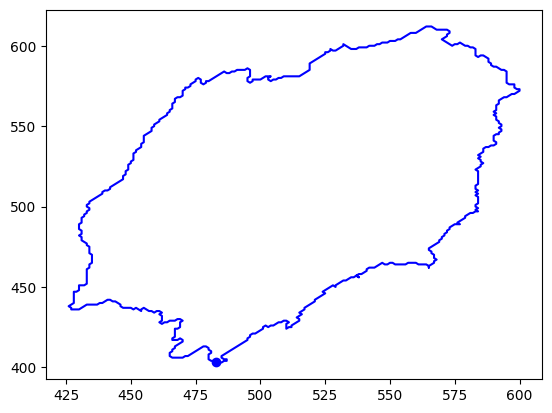

In [8]:
cell_idx = 1
plt.plot(cells[cell_idx][:, 0], cells[cell_idx][:, 1], "blue")
plt.plot(cells[cell_idx][0, 0], cells[cell_idx][0, 1], "blue", marker="o");

The size of each class is displayed below:

In [9]:
ds = {}

n_cells_arr = gs.zeros((4, 2))

for i, mutation in enumerate(MUTATIONS):
    print(f"{mutation} :")
    ds[mutation] = {}
    for j, surface in enumerate(SURFACES):
        to_keep = gs.array(
            [
                one_mutation == mutation and one_surface == surface
                for one_mutation, one_surface in zip(mutations, surfaces)
            ]
        )
        ds[mutation][surface] = [
            cell_i for cell_i, to_keep_i in zip(cells, to_keep) if to_keep_i
        ]
        nb = len(ds[mutation][surface])
        print(f"\t {nb} {surface}")
        n_cells_arr[i, j] = nb

n_cells_df = pd.DataFrame({"FN": n_cells_arr[:, 0], "GDA": n_cells_arr[:, 1]})
n_cells_df = n_cells_df.set_index(MUTATIONS)

display(n_cells_df)
# display(ds)

AKT :
	 341 FN
	 429 GDA
APRE19 :
	 315 FN
	 608 GDA
MEKDD :
	 319 FN
	 460 GDA
RAS :
	 539 FN
	 860 GDA


FN    GDA
AKT     341.0  429.0
APRE19  315.0  608.0
MEKDD   319.0  460.0
RAS     539.0  860.0

The above code also created a dictionnary `ds`, that contains the cell boundaries data sorted by `mutation` and cell `surface`. To access all the cells corresponding to a given mutation and a given surface, we use the syntax `ds[mutation][surface]` as in the following code that computes the number of cells in the cytd-dlm8 class.

In [10]:
len(ds["AKT"]["FN"])

341

We have organized the cell data into the dictionnary `ds`. Before proceeding to the actual data analysis, we provide an auxiliary function `apply_func_to_ds`.

In [11]:
def apply_func_to_ds(input_ds, func):
    """Apply the input function func to the input dictionnary input_ds.

    This function goes through the dictionnary structure and applies
    func to every cell in input_ds[mutation][surface].

    It stores the result in a dictionnary output_ds that is returned
    to the user.

    Parameters
    ----------
    input_ds : dict
        Input dictionnary, with keys mutation-line.
    func : callable
        Function to be applied to the values of the dictionnary, i.e.
        the cells.

    Returns
    -------
    output_ds : dict
        Output dictionnary, with the same keys as input_ds.
    """
    output_ds = {}
    
    for mutation in MUTATIONS:
        # print("mutation is:", mutation)
        output_ds[mutation] = {}
        for surface in SURFACES:
            # print("surface is:", surface)
            output_list = []
            i = 0
            for one_cell in input_ds[mutation][surface]:
                # print("index is:", i)
                # print("one cell is:", one_cell)
                # cell_func = func(one_cell)
                output_list.append(func(one_cell))
                i += 1
            output_ds[mutation][surface] = gs.array(output_list)
    return output_ds

Now we can move on to the actual data analysis, starting with a preprocessing of the cell boundaries.

# 3. Preprocessing 

### Interpolation: Encoding Discrete Curves With Same Number of Points

As we need discrete curves with the same number of sampled points to compute pairwise distances, the following interpolation is applied to each curve, after setting the number of sampling points.

To set up the number of sampling points, you can edit the following surface in the next cell:

In [12]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length / nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation


k_sampling_points = 200

To illustrate the result of this interpolation, we compare for a randomly chosen cell the original curve with the correponding interpolated one (to visualize another cell, you can simply re-run the code).

(458.4512435913086, 570.0737503051757, 403.2852508544922, 595.009732055664)

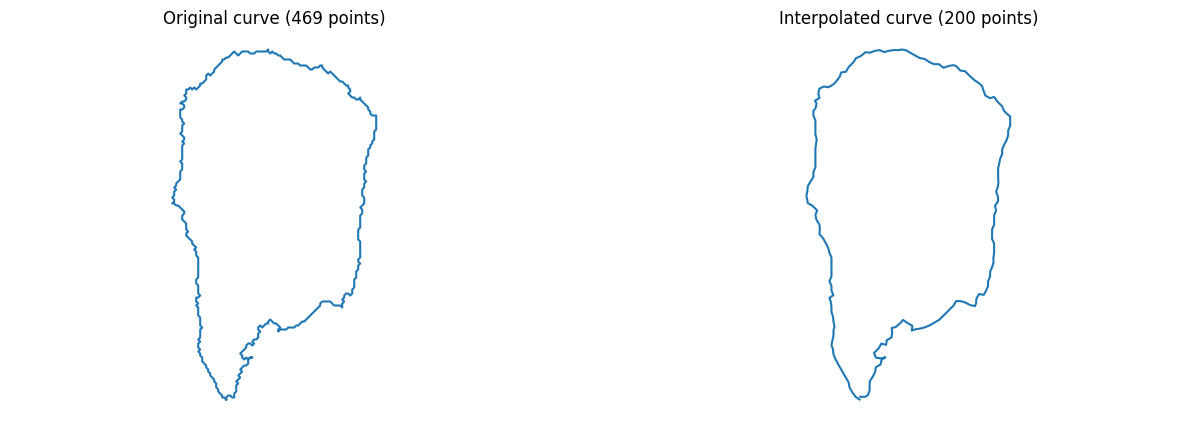

In [13]:
cell_rand = cells[gs.random.randint(len(cells))]
cell_interpolation = interpolate(cell_rand, k_sampling_points)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(cell_rand[:, 0], cell_rand[:, 1])
plt.axis("equal")
plt.title(f"Original curve ({len(cell_rand)} points)")
plt.axis("off")

fig.add_subplot(122)
plt.plot(cell_interpolation[:, 0], cell_interpolation[:, 1])
plt.axis("equal")
plt.title(f"Interpolated curve ({k_sampling_points} points)")
plt.axis("off")

# plt.savefig("interpolation.svg")

As the interpolation is working as expected, we use the auxiliary function `apply_func_to_ds` to apply the function `func=interpolate` to the dataset `ds`, i.e. the dictionnary containing the cells boundaries.

We obtain a new dictionnary, `ds_interp`, with the interpolated cell boundaries.

In [14]:
ds_interp = apply_func_to_ds(
    input_ds=ds, func=lambda x: interpolate(x, k_sampling_points)
)

For each key mutation-control, we check that the number of sampling points is the one expected, i.e. `k_sampling_points`:

In [15]:
print(ds_interp["AKT"]["FN"].shape)

(341, 200, 2)


The shape of an array of cells in `ds_interp[mutation][cell]` is therefore: `("number of cells in mutation-surface", "number of sampling points", 2)`, where 2 refers to the fact that we are considering cell shapes in 2D. 

### Visualization of Interpolated Dataset of Curves

We visualize the curves obtained, for a sample of control cells and treated cells (second row shows control, i.e. non-treated cells; other rows rows shows treated cells) across cell surfaces (left and orange for FN and right and blue for GDA).

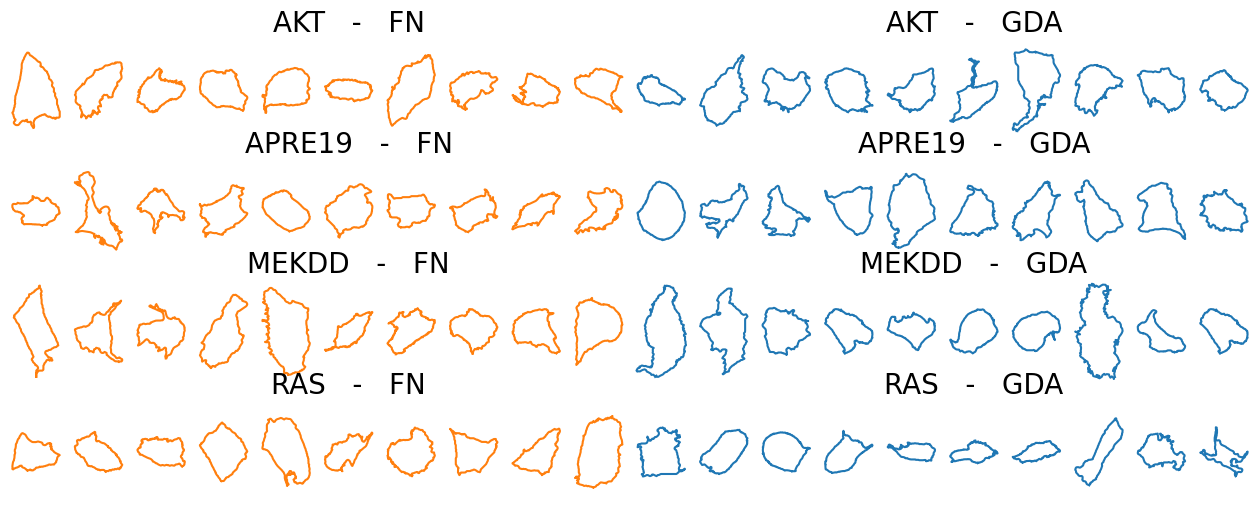

In [16]:
n_cells_to_plot = 10

fig = plt.figure(figsize=(16, 6))
count = 1
for mutation in MUTATIONS:
    for surface in SURFACES:
        cell_data = ds_interp[mutation][surface]
        for i_to_plot in range(n_cells_to_plot):
            cell = gs.random.choice(cell_data)
            fig.add_subplot(4, 2 * n_cells_to_plot, count)
            count += 1
            plt.plot(cell[:, 0], cell[:, 1], color="C" + str(int((surface == "FN"))))
            plt.axis("equal")
            plt.axis("off")
            if i_to_plot == n_cells_to_plot // 2:
                plt.title(f"{mutation}   -   {surface}", fontsize=20)
# plt.savefig("cancer_cell_sample.svg")

Visual inspection of these curves seems to indicate more protusions appearing in treated cells, compared with control ones. This is in agreement with the physiological impact of the drugs, which are known to perturb the internal cytoskeleton connected to the cell membrane. Using the elastic metric, our goal will be to see if we can quantitatively confirm these differences.

### Remove duplicate samples in curves

During interpolation it is likely that some of the discrete curves in the dataset are downsampled from higher number of discrete data points to lower number of data points. Hence, two sampled data points that are close enough may end up overlapping after interpolation and hence such data points have to be dealt with specifically. 

In [17]:
import numpy as np

def preprocess(curve, tol=1e-10):
    """Preprocess curve to ensure that there are no consecutive duplicate points.

    Returns
    -------
    curve : discrete curve
    """

    dist = curve[1:] - curve[:-1]
    dist_norm = np.sqrt(np.sum(np.square(dist), axis=1))

    if np.any( dist_norm < tol ):
        for i in range(len(curve)-1):
            if np.sqrt(np.sum(np.square(curve[i+1] - curve[i]), axis=0)) < tol:
                curve[i+1] = (curve[i] + curve[i+2]) / 2

    return curve

### Alignment

Our goal is to study the cell boundaries in our dataset, as points in a shape space of closed curves quotiented by translation, scaling, and rotation, so these transformations do not affect our measure of distance between curves.

In practice, we apply functions that were initially designed to center (substract the barycenter), rescale (divide by the Frobenius norm) and then align (find the rotation minimizing the L² distance) two sets of landmarks. These operations will be performed by leveraging the geometry of the so-called Kendall preshape spaces and specifically its method `PRESHAPE_SPACE.projection`, as shown below. Details on Kendall shape spaces can be found in the [module implementing them](https://github.com/geomstats/geomstats/blob/master/geomstats/geometry/pre_shape.py) or the notebooks using them. 

Additionally, since we are working with closed curves, the starting point associated with the parametrization of the discrete curves is also arbitrary. Thus, we conduct an exhaustive search to find which parametrization produces the best alignment according to the above procedure (i.e. the distance to the base curve is the smallest). This exhaustive search is implemented in the function `exhaustive_align` below.

In [18]:
from geomstats.geometry.pre_shape import PreShapeSpace

M_AMBIENT = 2

PRESHAPE_SPACE = PreShapeSpace(m_ambient=M_AMBIENT, k_landmarks=k_sampling_points)

PRESHAPE_SPACE.equip_with_group_action("rotations")
PRESHAPE_SPACE.equip_with_quotient_structure()


def exhaustive_align(curve, base_curve):
    """Align curve to base_curve to minimize the L² distance.

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)
    base_curve = gs.array(base_curve)
    for shift in range(nb_sampling):
        reparametrized = [curve[(i + shift) % nb_sampling] for i in range(nb_sampling)]
        aligned = PRESHAPE_SPACE.fiber_bundle.align(point=gs.array(reparametrized), base_point=base_curve)
        distances[shift] = PRESHAPE_SPACE.embedding_space.metric.norm(
            gs.array(aligned) - gs.array(base_curve)
        )
    shift_min = gs.argmin(distances)
    reparametrized_min = [
        curve[(i + shift_min) % nb_sampling] for i in range(nb_sampling)
    ]
    aligned_curve = PRESHAPE_SPACE.fiber_bundle.align(
        point=gs.array(reparametrized_min), base_point=base_curve
    )
    return aligned_curve

We perform the pre-shape projection and the exhaustive alignment of the cells against the base curve, which is chosen to be the first cell curve of the dataset, called `BASE_CURVE`. 

Both the projection and the alignment make use of our auxiliary function `apply_func_to_ds`, which finally outputs a dataset of cell curves organized within a dictionnary called `ds_align`.

In [19]:
ds_proc = apply_func_to_ds(ds_interp, func=lambda x: preprocess(x))

ds_proj = apply_func_to_ds(ds_proc, func= lambda x: PRESHAPE_SPACE.projection(x, scale=False))
print(ds_proj["APRE19"]["FN"].shape)

BASE_CURVE = ds_proj["APRE19"]["FN"][0]
print("Shape of BASE_CURVE:", BASE_CURVE.shape)

ds_align = apply_func_to_ds(ds_proj, func=lambda x: exhaustive_align(x, BASE_CURVE))
# print(ds_align["APRE19"]["FN"].shape)


(315, 200, 2)
Shape of BASE_CURVE: (200, 2)


In [20]:
def remove_cell(mutation, surface, index):
    tmp_1 = ds_align[mutation][surface][:index]
    tmp_2 = ds_align[mutation][surface][index+1:]
    tmp = np.concatenate((tmp_1, tmp_2))
    ds_align[mutation][surface] = tmp

    tmp_1 = ds_proc[mutation][surface][:index]
    tmp_2 = ds_proc[mutation][surface][index+1:]
    tmp = np.concatenate((tmp_1, tmp_2))
    ds_proc[mutation][surface] = tmp

    tmp_1 = ds_proj[mutation][surface][:index]
    tmp_2 = ds_proj[mutation][surface][index+1:]
    tmp = np.concatenate((tmp_1, tmp_2))
    ds_proj[mutation][surface] = tmp

In [34]:
remove_cell('APRE19', 'GDA', 183)
remove_cell('MEKDD', 'FN', 147)
remove_cell('RAS', 'GDA', 43)

We visually evaluate that methods perform correctly, by plotting the results of the projection and the alignment through the following code.

Text(0.5, 1.0, 'Aligned curve')

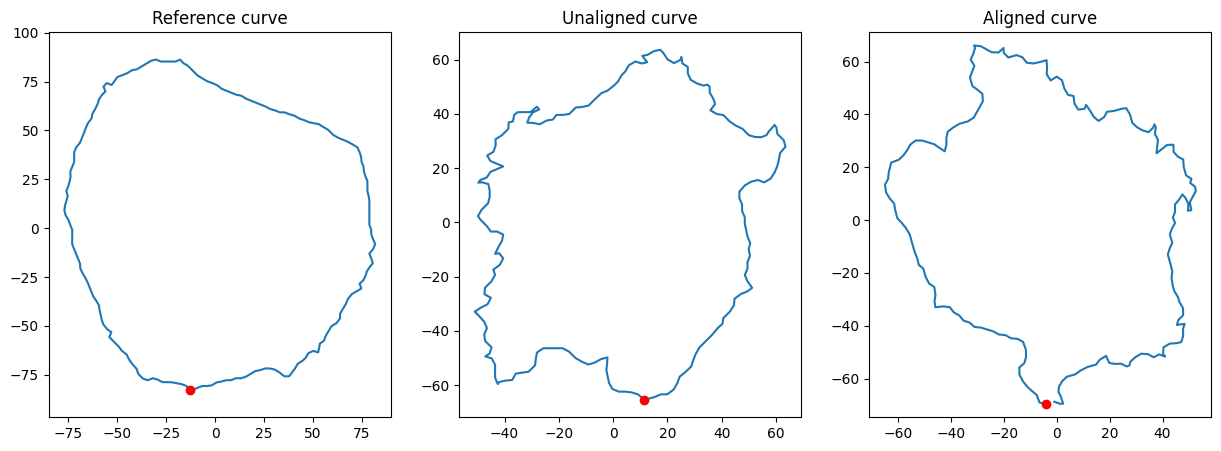

In [35]:
i_rand = gs.random.randint(n_cells_df.loc["APRE19"]["FN"])
unaligned_cell = ds_proj["APRE19"]["FN"][i_rand]
aligned_cell = ds_align["APRE19"]["FN"][i_rand]

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1])
plt.plot(BASE_CURVE[0, 0], BASE_CURVE[0, 1], "ro")
plt.axis("equal")
plt.title("Reference curve")

fig.add_subplot(132)
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1])
plt.plot(unaligned_cell[0, 0], unaligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1])
plt.plot(aligned_cell[0, 0], aligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Aligned curve")

# plt.savefig("alignment.svg")

In the plot above, the red dot shows the start of the parametrization of each curve. The right curve has been rotated from the curve in the middle, to be aligned with the left (reference) curve, which represents the first cell of the dataset. The starting point (in red) of this right curve has been also set to align with the reference.

# 4 Data Analysis

## Compute Mean Cell Shape of the Whole Dataset: "Global" Mean Shape

We want to compute the mean cell shape of the whole dataset. Thus, we first combine all the cell shape data into a single array.

In [36]:
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import DiscreteCurves, L2CurvesMetric


CURVES_SPACE_SRV = DiscreteCurves(Euclidean(dim=2), k_sampling_points=200)


In [37]:
cell_shapes_list = []
for mutation in MUTATIONS:
    for surface in SURFACES:
        cell_shapes_list.extend(ds_align[mutation][surface])

cell_shapes = gs.array(cell_shapes_list)
print(cell_shapes.shape)

(3868, 200, 2)


We compute the mean cell shape by using the SRV metric defined on the space of curves' shapes. The space of curves' shape is a manifold: we use the Frechet mean, associated to the SRV metric, to get the mean cell shape.

We only use the first 500 cells of the dataset, for numerical reasons: the FrechetMean is failing upon incorporating shapes from the remainder of the dataset.

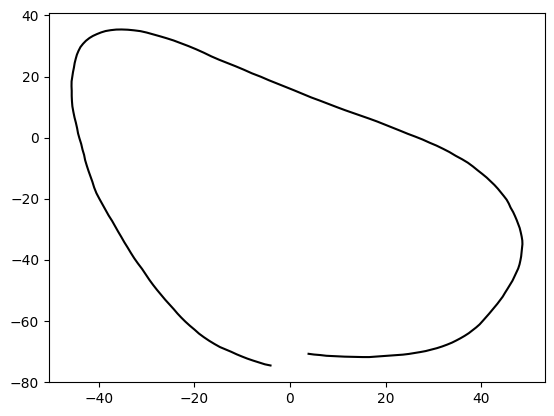

In [38]:
from geomstats.learning.frechet_mean import FrechetMean

mean = FrechetMean(space=CURVES_SPACE_SRV)
mean.fit(cell_shapes[:500])

mean_estimate = mean.estimate_

plt.plot(mean_estimate[:, 0], mean_estimate[:, 1], "black");

The mean cell shape does indeed look like a cell shape. We note that there is a discontinuity in the cell because we have modeled the curves' boundaries as open curves. The space of curves considered here is also the space of (open) discrete curves.

Unfortunately, sometimes there could be Nans in the values of the mean shape. If this is the case, this code removes them manually, and re-interpolate the mean shape.

In [39]:
print(gs.sum(gs.isnan(mean_estimate)))
mean_estimate_clean = mean_estimate[~gs.isnan(gs.sum(mean_estimate, axis=1)), :]
print(mean_estimate_clean.shape)
mean_estimate_clean = interpolate(mean_estimate_clean, k_sampling_points)
print(gs.sum(gs.isnan(mean_estimate_clean)))
print(mean_estimate_clean.shape)

0
(200, 2)
0
(200, 2)


We plot the mean cell shape, superimposed on top of the dataset of cells (displayed in light grey underneath).

(3868, 200, 2)


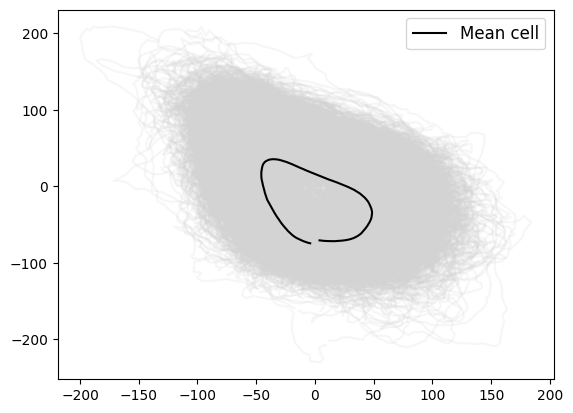

In [40]:
print(cell_shapes.shape)
for cell in cell_shapes:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)

plt.plot(
    mean_estimate_clean[:, 0], mean_estimate_clean[:, 1], "black", label="Mean cell"
)
plt.legend(fontsize=12);

We see that the scale and alignment of the mean shape is slightly off. This makes sense, as our computations have quotiented out scale and alignment. We correct it manually.

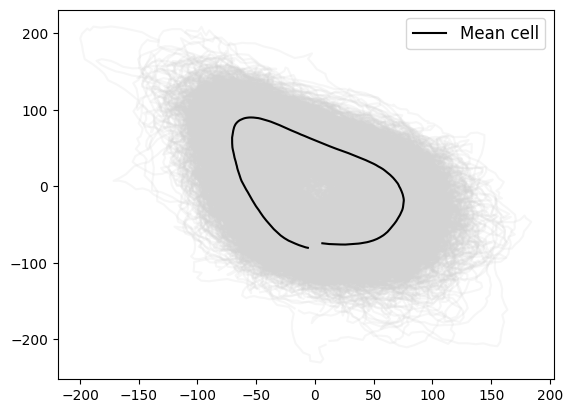

In [41]:
mean_estimate_aligned = 1.55 * (
    mean_estimate_clean - gs.mean(mean_estimate_clean, axis=0)
)

for cell in cell_shapes:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)

plt.plot(
    mean_estimate_aligned[:, 0], mean_estimate_aligned[:, 1], "black", label="Mean cell"
)
plt.legend(fontsize=12);

We visualize the same plot, but now:
- closing the mean shape that becomes a closed curve
- plotting underneath the mean shape the distribution of the sampling points of all the curves of the dataset, through a kernel density estimation.

Visualizing the full datasets of 640+ cells takes a long time. Therefore, we also select only 200 cells, randomly, within the dataset.

In [42]:
mean_estimate_aligned_bis = gs.vstack(
    [mean_estimate_aligned[4:], mean_estimate_aligned[-1]]
)

Text(0.5, 1.0, 'Global mean shape superimposed on the\n dataset of cells')

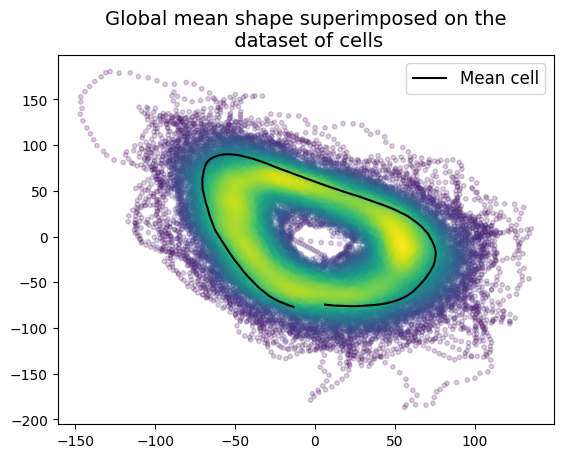

In [43]:
from scipy.stats import gaussian_kde

cells_to_plot = cell_shapes[gs.random.randint(len(cell_shapes), size=200)]
points_to_plot = cells_to_plot.reshape(-1, 2)

z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
z_norm = z / z.max()

plt.scatter(points_to_plot[:, 0], points_to_plot[:, 1], alpha=0.2, c=z_norm, s=10)
plt.plot(
    mean_estimate_aligned_bis[:, 0],
    mean_estimate_aligned_bis[:, 1],
    "black",
    label="Mean cell",
)
plt.legend(fontsize=12)
plt.title("Global mean shape superimposed on the\n dataset of cells", fontsize=14)

# plt.savefig("global_mean_shape.svg")

This plot allows to verify that the mean shape that has been computed makes sense.

Also we compute the linear mean

0
(200, 2)
0
(200, 2)


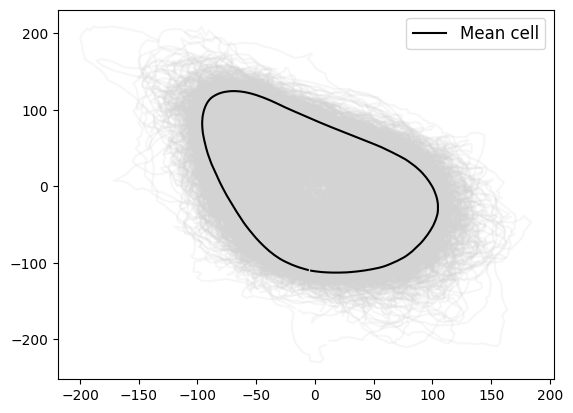

In [44]:
linear_mean_estimate = gs.mean(cell_shapes, axis=0)
print(gs.sum(gs.isnan(linear_mean_estimate)))
linear_mean_estimate_clean = linear_mean_estimate[~gs.isnan(gs.sum(linear_mean_estimate, axis=1)), :]
print(linear_mean_estimate_clean.shape)

linear_mean_estimate_clean = interpolate(linear_mean_estimate_clean, k_sampling_points)

print(gs.sum(gs.isnan(linear_mean_estimate_clean)))
print(linear_mean_estimate_clean.shape)

linear_mean_estimate_aligned = 1.55 * (
    linear_mean_estimate_clean - gs.mean(linear_mean_estimate_clean, axis=0)
)

for cell in cell_shapes:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)

plt.plot(
    linear_mean_estimate_aligned[:, 0], linear_mean_estimate_aligned[:, 1], "black", label="Mean cell"
)
plt.legend(fontsize=12);

Not sure how but the 1.55 makes the seperation of the histogram better, though it does not look like the mean of the cell shapes.

# Analyze Distances to the "Global"  Mean Shape

We consider each of the subgroups of cells, defined by their mutation and surface. We wish to study how far each of this group is from the global mean shape. We compute the list of distances to the global mean shape.

In [45]:
print(mean_estimate_aligned.shape)
print(len(gs.unique(mean_estimate_aligned)))

(200, 2)
400


In [46]:
dists_to_global_mean = apply_func_to_ds(
    ds_align, func=lambda x: CURVES_SPACE_SRV.metric.dist(x, mean_estimate_aligned)
)

dists_to_global_mean_list = []
for t in MUTATIONS:
    for l in SURFACES:
        dists_to_global_mean_list.extend(dists_to_global_mean[t][l])

As an example, the following code shows the 5 first distances of cell shapes.

In [47]:
dists_to_global_mean_list[:5]

[20.053211699059144,
 16.433724467219406,
 19.554892102128075,
 22.013424998810535,
 18.362249878667676]

We compute a few statistics about this list of distances to the global mean shape, checking:
- that there are no NaNs,
- what are the values of the min and max distances.

In [48]:
gs.where(gs.isnan(dists_to_global_mean_list))

(array([], dtype=int64),)

In [49]:
min_dists = min(dists_to_global_mean_list)
max_dists = max(dists_to_global_mean_list)
print(min_dists, max_dists)

7.761775763720603 34.38620144716446


In [50]:
xx = gs.linspace(gs.floor(min_dists), gs.ceil(max_dists), 100)

We plot the distances to the mean global shape, by splitting them into the three mutation groups.

In [51]:
from scipy import stats

Text(0.5, 0.98, 'Histograms of SRV distances (a=1, b=0.5) to global mean cell')

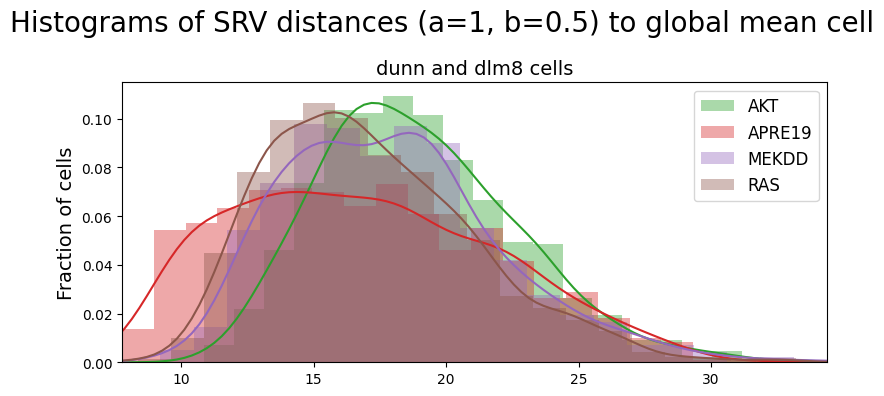

In [52]:
fig, axs = plt.subplots(1, sharex=True, sharey=True, tight_layout=True, figsize=(8, 4))

for i, mutation in enumerate(MUTATIONS):
    distances = []
    for j, surface in enumerate(SURFACES):
        distances.extend(
            dists_to_global_mean[mutation][surface][
                ~gs.isnan(dists_to_global_mean[mutation][surface])
            ]
        )
    color = "C" + str(2 + i)
    axs.hist(distances, bins=20, alpha=0.4, density=True, color=color, label=mutation)
    kde = stats.gaussian_kde(distances)
    axs.plot(xx, kde(xx), color=color)
    axs.set_xlim((min_dists, max_dists))
    axs.legend(fontsize=12)

    axs.set_title(f"dunn and dlm8 cells", fontsize=14)
    axs.set_ylabel("Fraction of cells", fontsize=14)


fig.suptitle("Histograms of SRV distances (a=1, b=0.5) to global mean cell", fontsize=20)
# plt.savefig("dist_to_global_mean_per_mutation2.svg")

We observe that each of these distributions seems to be bimodal, which might corresponds to the fact that we have actually two cell surfaces per mutation. We verify this hypothesis.

Text(0.5, 0.98, 'Histograms of SRV distances (a=1, b=0.5) to global mean cell')

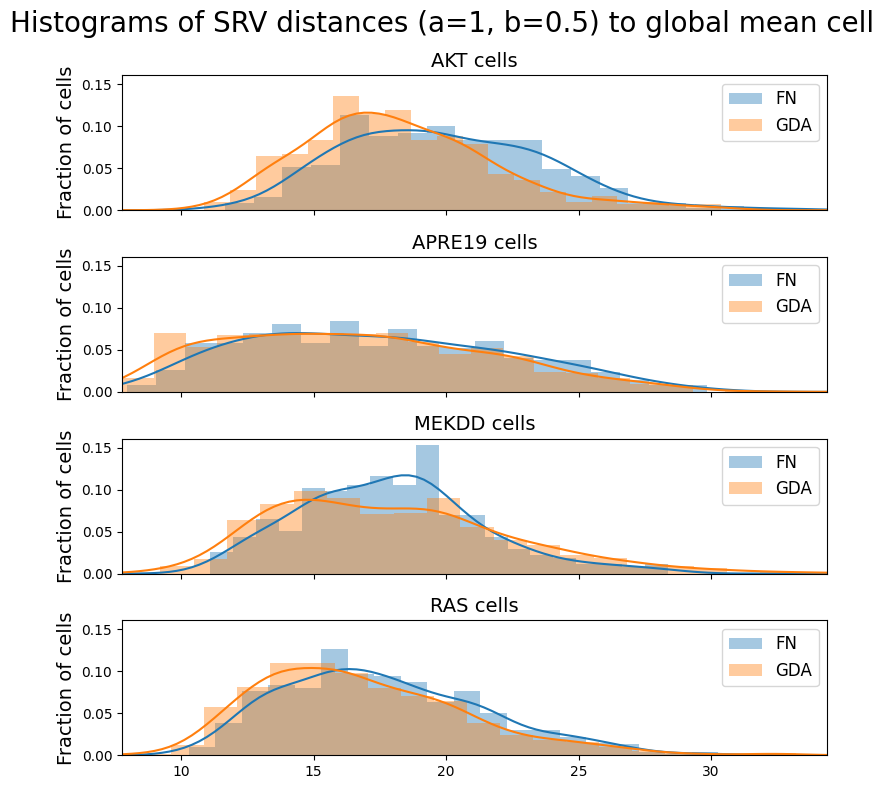

In [53]:
fig, axs = plt.subplots(4, sharex=True, sharey=True, tight_layout=True, figsize=(8, 8))

axs[0].set_xlim((min_dists, max_dists))
for i, mutation in enumerate(MUTATIONS):
    for j, surface in enumerate(SURFACES):
        distances = dists_to_global_mean[mutation][surface][
            ~gs.isnan(dists_to_global_mean[mutation][surface])
        ]
        color = f"C{j}"
        axs[i].hist(
            distances, bins=20, alpha=0.4, density=True, color=color, label=surface
        )
        kde = stats.gaussian_kde(distances)
        axs[i].plot(xx, kde(xx), color=color)

    axs[i].set_title(f"{mutation} cells", fontsize=14)
    axs[i].set_ylabel("Fraction of cells", fontsize=14)
    axs[i].legend(fontsize=12)

fig.suptitle("Histograms of SRV distances (a=1, b=0.5) to global mean cell", fontsize=20)
# plt.savefig("dist_to_global_mean_per_class2.svg")

<!-- For the mutations jasp and cytd, it seems indeed that the bimodality is explained by the two cell surfaces. -->

We plot the distances to the mean global shape, while splitting them into the three mutation groups, and separating two cell surfaces.

Text(0.5, 0.98, 'Histograms of SRV distances (a=1, b=0.5) to global mean cell')

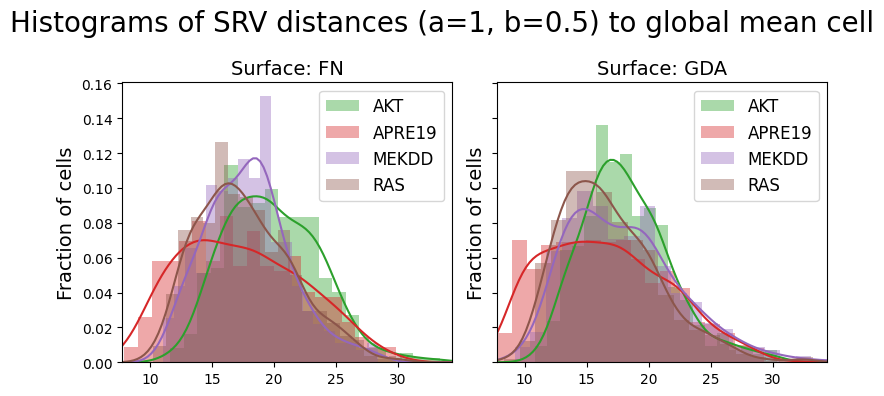

In [54]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, tight_layout=True, figsize=(8, 4))

for j, surface in enumerate(SURFACES):
    distances = []
    for i, mutation in enumerate(MUTATIONS):
        distances = dists_to_global_mean[mutation][surface][~gs.isnan(dists_to_global_mean[mutation][surface])]
        color = "C" + str(2 + i)
        axs[j].hist(distances, bins=20, alpha=0.4, density=True, color=color, label=mutation)
        kde = stats.gaussian_kde(distances)
        axs[j].plot(xx, kde(xx), color=color)
        axs[j].set_xlim((min_dists, max_dists))
        axs[j].legend(fontsize=12)

        axs[j].set_title(f"Surface: {surface}", fontsize=14)
        axs[j].set_ylabel("Fraction of cells", fontsize=14)


fig.suptitle("Histograms of SRV distances (a=1, b=0.5) to global mean cell", fontsize=20)
# plt.savefig("dist_to_global_mean_per_mutation2.svg")

In comparison, we plot the distances to the mean global shape, using the linear metric, while splitting them into the three mutation groups, and separating two cell surfaces.

Compute distances to linear mean

In [55]:
linear_dists_to_global_mean = apply_func_to_ds(
    ds_align, func=lambda x: gs.linalg.norm(linear_mean_estimate_aligned - x) 
)

In [56]:
linear_dists_to_global_mean = apply_func_to_ds(
    ds_align, func=lambda x: gs.linalg.norm(linear_mean_estimate_aligned - x) 
)

linear_dists_to_global_mean_list = []
for t in MUTATIONS:
    for l in SURFACES:
        linear_dists_to_global_mean_list.extend(linear_dists_to_global_mean[t][l])

In [57]:
linear_min_dists = min(linear_dists_to_global_mean_list)
linear_max_dists = max(linear_dists_to_global_mean_list)
linear_xx = gs.linspace(gs.floor(linear_min_dists), gs.ceil(linear_max_dists), 100)
print(linear_min_dists, linear_max_dists)

120.18576566220733 1165.6836135528404


Text(0.5, 0.98, 'Histograms of linear distances (a=1, b=0.5) to global mean cell')

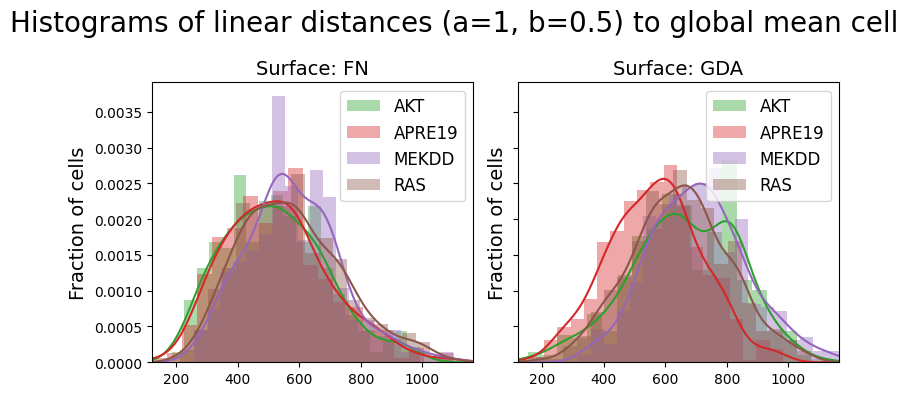

In [58]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, tight_layout=True, figsize=(8, 4))

for j, surface in enumerate(SURFACES):
    distances = []
    for i, mutation in enumerate(MUTATIONS):
        distances = linear_dists_to_global_mean[mutation][surface][~gs.isnan(linear_dists_to_global_mean[mutation][surface])]
        color = "C" + str(2 + i)
        axs[j].hist(distances, bins=20, alpha=0.4, density=True, color=color, label=mutation)
        kde = stats.gaussian_kde(distances)
        axs[j].plot(linear_xx, kde(linear_xx), color=color)
        axs[j].set_xlim((linear_min_dists, linear_max_dists))
        axs[j].legend(fontsize=12)

        axs[j].set_title(f"Surface: {surface}", fontsize=14)
        axs[j].set_ylabel("Fraction of cells", fontsize=14)


fig.suptitle("Histograms of linear distances (a=1, b=0.5) to global mean cell", fontsize=20)
# plt.savefig("dist_to_global_mean_per_mutation2.svg")

In order to better understand which cells correspond to which distance, on the above plot, we run the following code. This code find a given number of quantiles within the distance's histogram, and plots the corresponding cell, for each mutation and each surface.

Text(0.5, -0.01, 'Quantiles for SRV metric (a=1, b=0.5) using global mean')

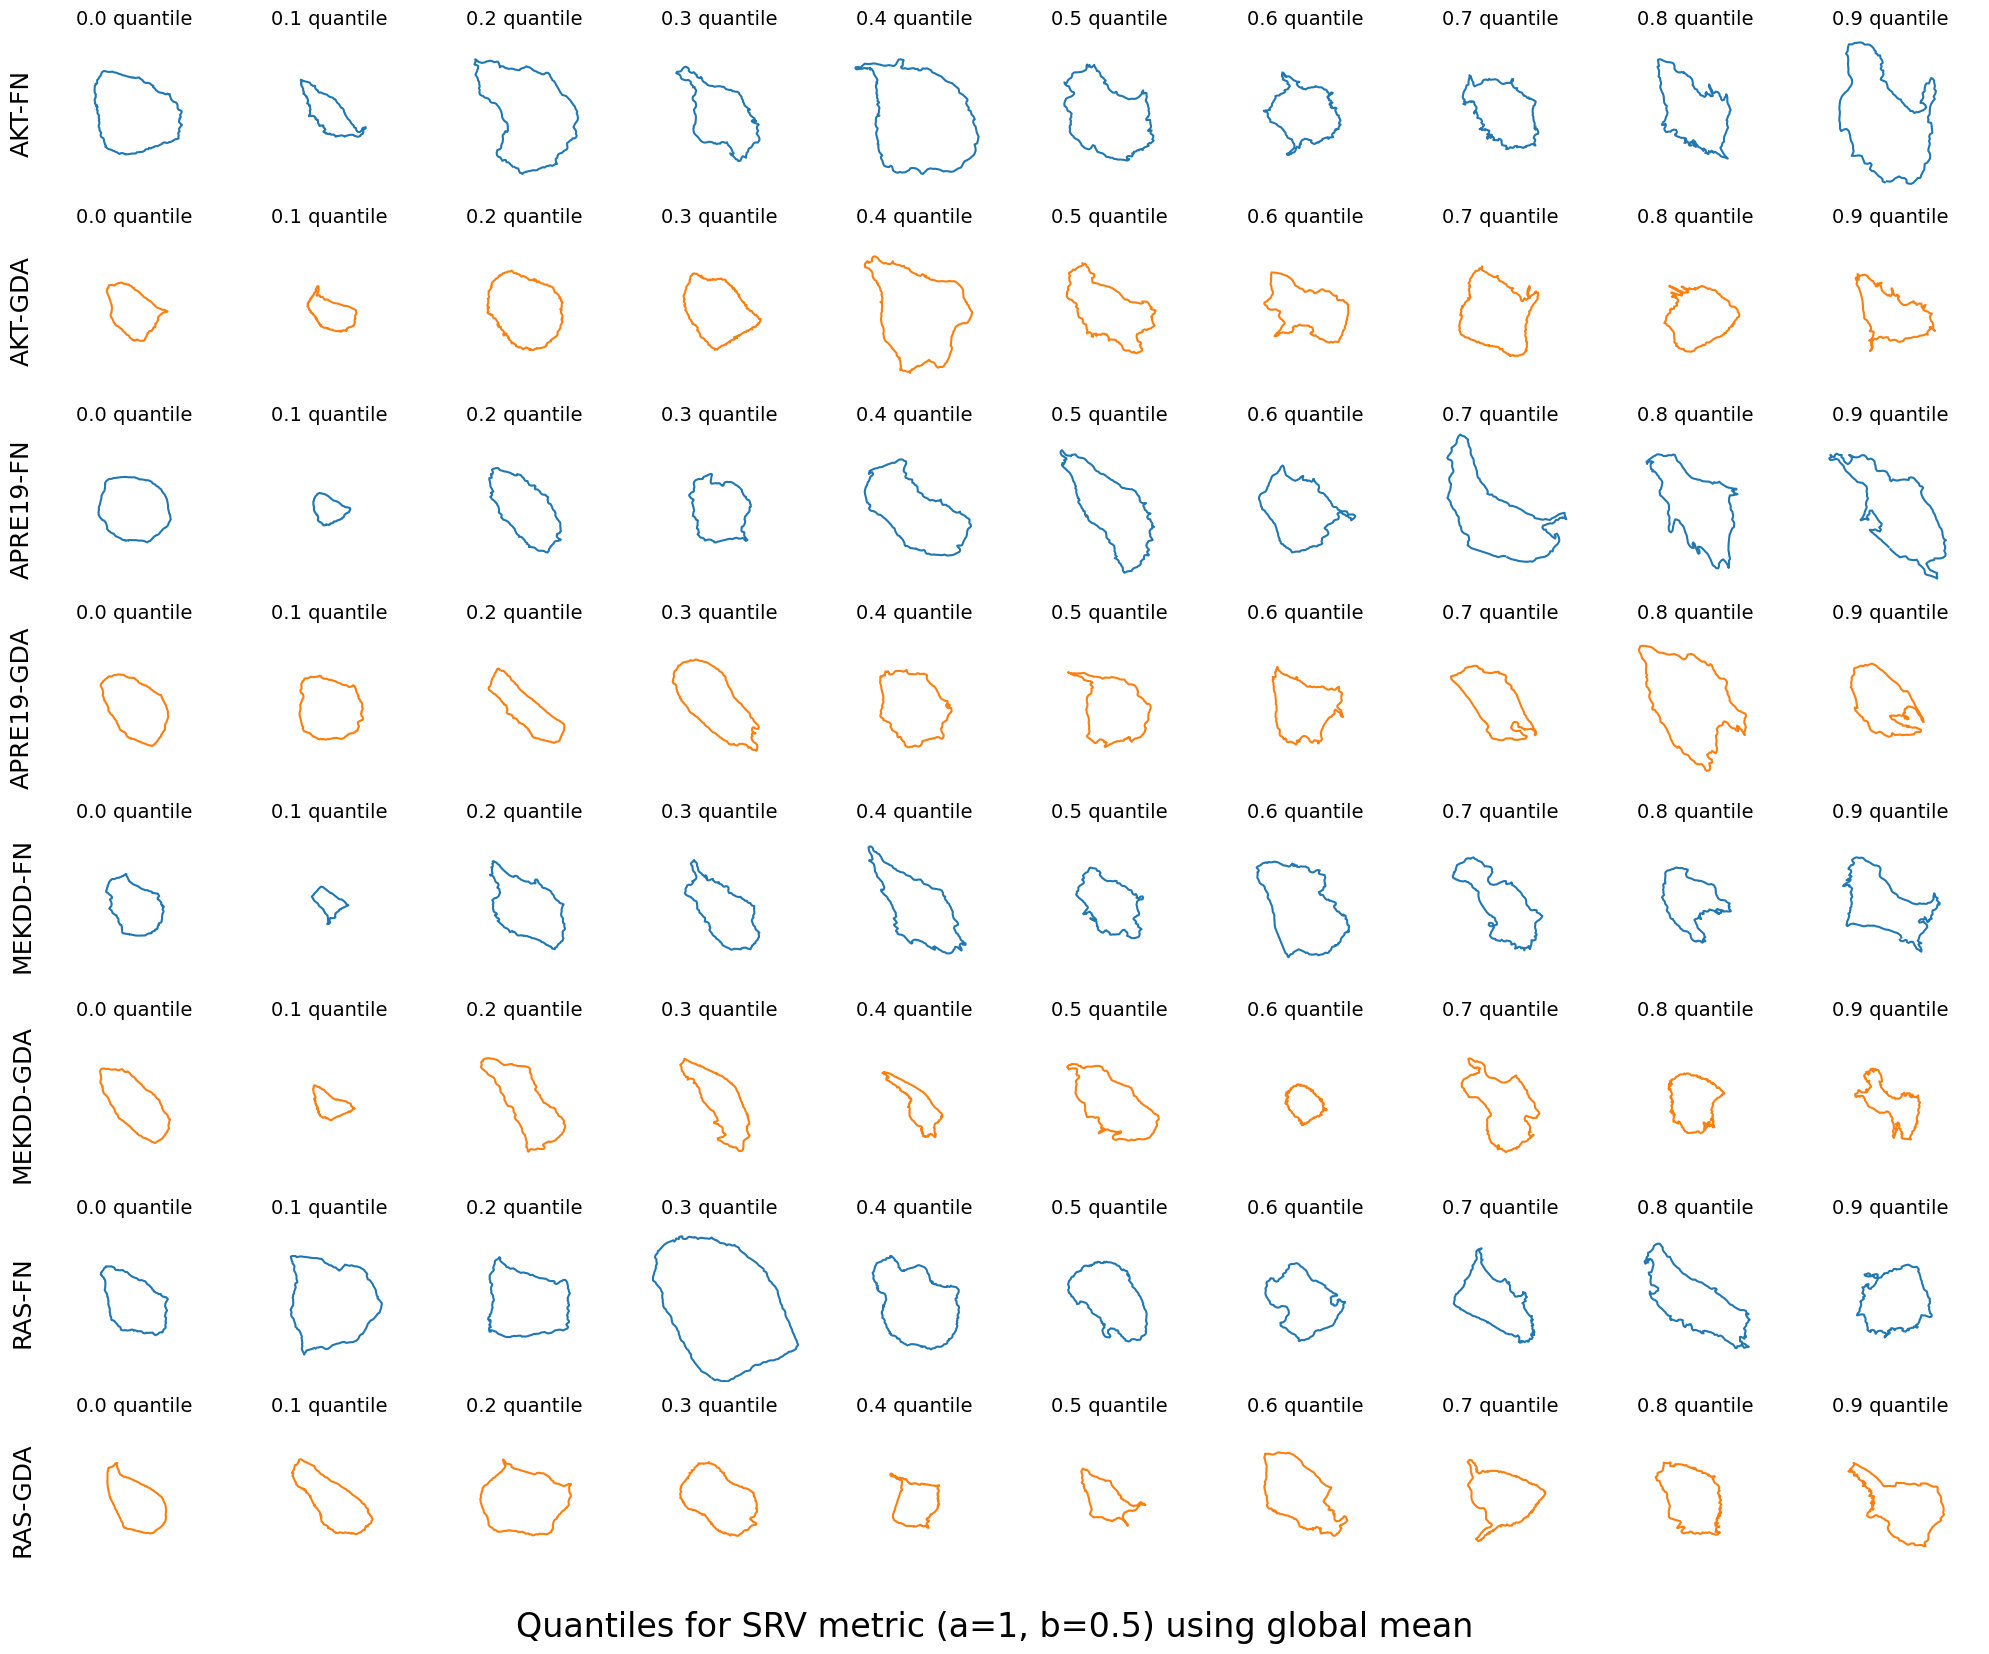

In [73]:
n_quantiles = 10
fig, axes = plt.subplots(
    nrows=len(MUTATIONS) * len(SURFACES),
    ncols=n_quantiles,
    figsize=(20, 2 * len(SURFACES) * len(MUTATIONS)),
)

for i, mutation in enumerate(MUTATIONS):
    for j, surface in enumerate(SURFACES):
        dists_list = dists_to_global_mean[mutation][surface]
        dists_list = [d + 0.0001 * gs.random.rand(1)[0] for d in dists_list]
        cells_list = list(ds_align[mutation][surface])
        assert len(dists_list) == len(dists_list)
        n_cells = len(dists_list)

        zipped_lists = zip(dists_list, cells_list)
        sorted_pairs = sorted(zipped_lists)

        tuples = zip(*sorted_pairs)
        sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
        for i_quantile in range(n_quantiles):
            quantile = int(0.1 * n_cells * i_quantile)
            one_cell = sorted_cells_list[quantile]
            ax = axes[2 * i + j, i_quantile]
            ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{j}")
            ax.set_title(f"0.{i_quantile} quantile", fontsize=14)
            ax.set_xlim(-170, 170)
            ax.set_ylim(-170, 170)
            # ax.axis("off")
            # Turn off tick labels
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_visible(False)
            ax.spines["left"].set_visible(False)
            if i_quantile == 0:
                ax.set_ylabel(f"{mutation}-{surface}", rotation=90, fontsize=18)
plt.tight_layout()
plt.suptitle(f"Quantiles for SRV metric (a=1, b=0.5) using global mean", y=-0.01, fontsize=24)
# plt.savefig("quantiles.svg")

This code find a given number of quantiles within the distance's histogram, using SRV metric, and plots the corresponding cell, for each mutation and each surface.

Text(0.5, -0.01, 'Quantiles for linear metric (a=1, b=0.5) using global mean')

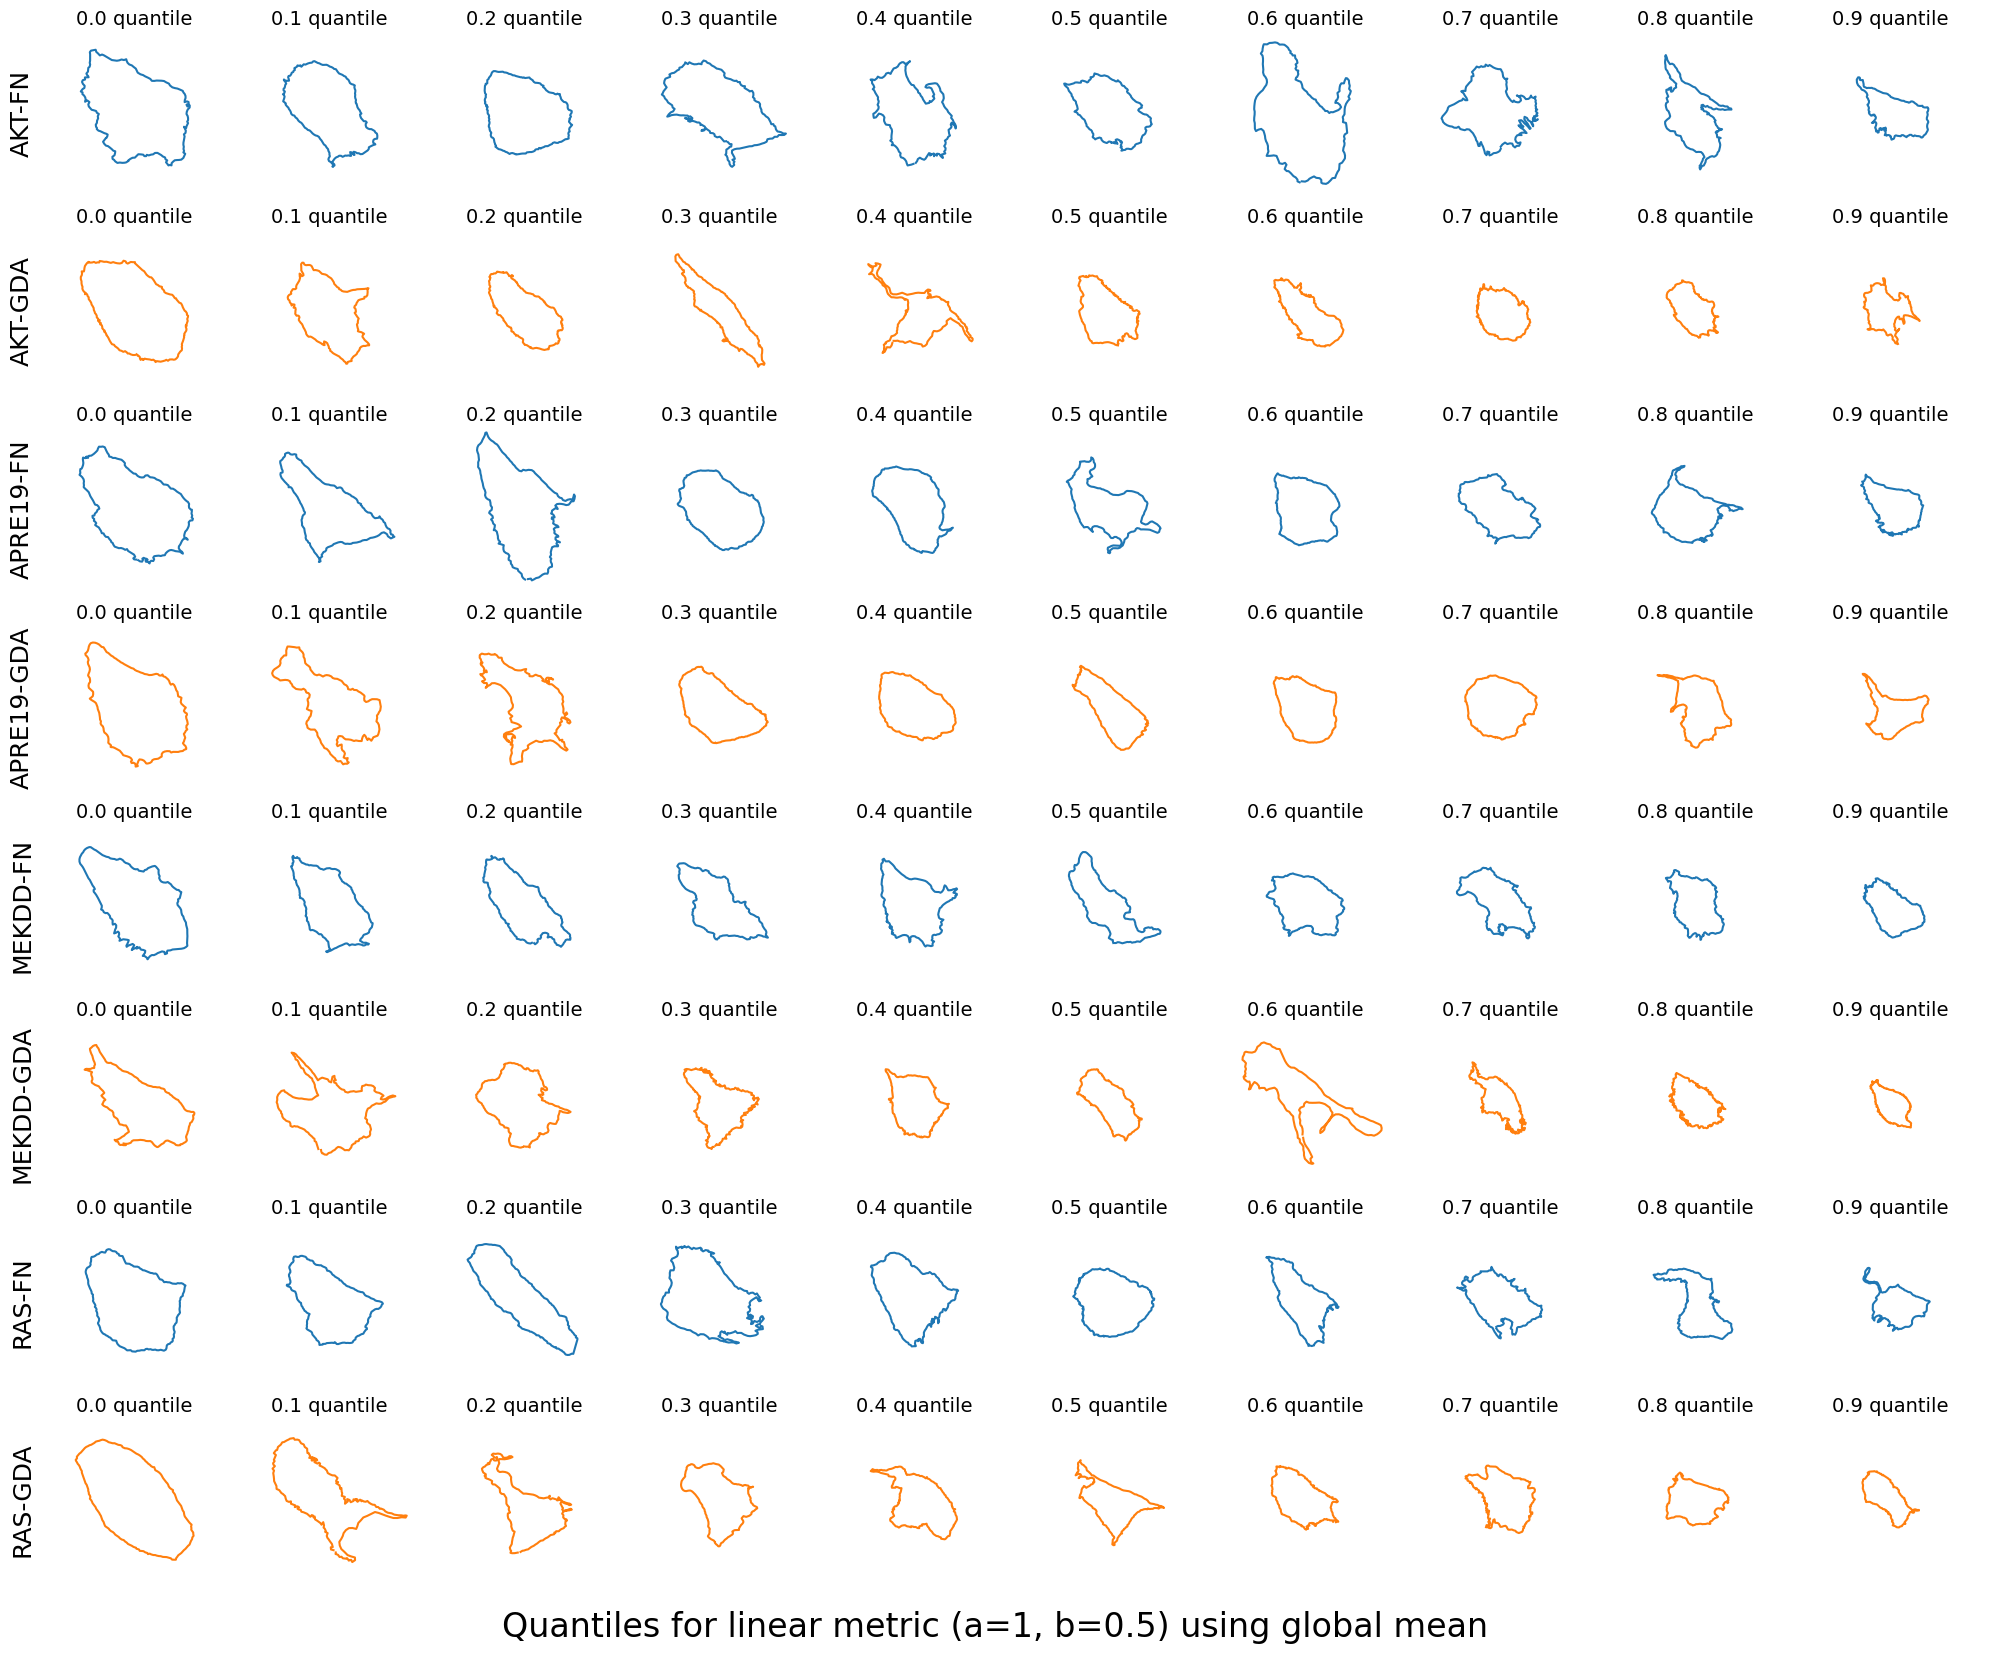

In [74]:
n_quantiles = 10
fig, axes = plt.subplots(
    nrows=len(MUTATIONS) * len(SURFACES),
    ncols=n_quantiles,
    figsize=(20, 2 * len(SURFACES) * len(MUTATIONS)),
)

for i, mutation in enumerate(MUTATIONS):
    for j, surface in enumerate(SURFACES):
        dists_list = linear_dists_to_global_mean[mutation][surface]
        dists_list = [d + 0.0001 * gs.random.rand(1)[0] for d in dists_list]
        cells_list = list(ds_align[mutation][surface])
        assert len(dists_list) == len(dists_list)
        n_cells = len(dists_list)

        zipped_lists = zip(dists_list, cells_list)
        sorted_pairs = sorted(zipped_lists)

        tuples = zip(*sorted_pairs)
        sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
        for i_quantile in range(n_quantiles):
            quantile = int(0.1 * n_cells * i_quantile)
            one_cell = sorted_cells_list[quantile]
            ax = axes[2 * i + j, i_quantile]
            ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{j}")
            ax.set_title(f"0.{i_quantile} quantile", fontsize=14)
            ax.set_xlim(-170, 170)
            ax.set_ylim(-170, 170)
            # ax.axis("off")
            # Turn off tick labels
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_visible(False)
            ax.spines["left"].set_visible(False)
            if i_quantile == 0:
                ax.set_ylabel(f"{mutation}-{surface}", rotation=90, fontsize=18)
plt.tight_layout()
plt.suptitle(f"Quantiles for linear metric (a=1, b=0.5) using global mean", y=-0.01, fontsize=24)
# plt.savefig("quantiles.svg")

This code find a given number of quantiles within the distance's histogram, using linear metric, and plots the corresponding cell, for each mutation and each surface.

# Visualization of the Mean of each mutation

The mean distances to the global mean shape differ. We also plot the mean shape for each of the subgroup, to get intuition on how the mean shape of each subgroup looks like.

In [61]:
mean_mutation_cells = {}
for mutation in MUTATIONS:
    mutation_cells = []
    for surface in SURFACES:
        mutation_cells.extend(ds_align[mutation][surface])
    mean_estimator = FrechetMean(space=CURVES_SPACE_SRV)
    mean_estimator.fit(gs.array(mutation_cells[:30]))
    mean_mutation_cells[mutation] = mean_estimator.estimate_

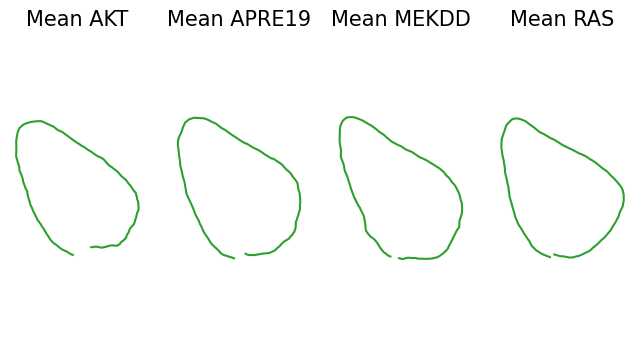

In [62]:
fig = plt.figure(figsize=(8, 4))
count = 1
for mutation in MUTATIONS:
    mean_cell = mean_mutation_cells[mutation]
    fig.add_subplot(1, len(MUTATIONS), count)
    count += 1
    plt.plot(mean_cell[:, 0], mean_cell[:, 1], color=f"C2")
    plt.axis("equal")
    plt.axis("off")
    plt.title(f"Mean {mutation}", fontsize=15)
# plt.savefig("cancer_mean_mutation_cells.svg")

In [63]:
mean_surface_cells = {}
for surface in SURFACES:
    surface_cells = []
    for mutation in MUTATIONS:
        surface_cells.extend(ds_align[mutation][surface])
    mean_estimator = FrechetMean(space=CURVES_SPACE_SRV)
    mean_estimator.fit(gs.array(surface_cells[:225]))
    mean_surface_cells[surface] = mean_estimator.estimate_

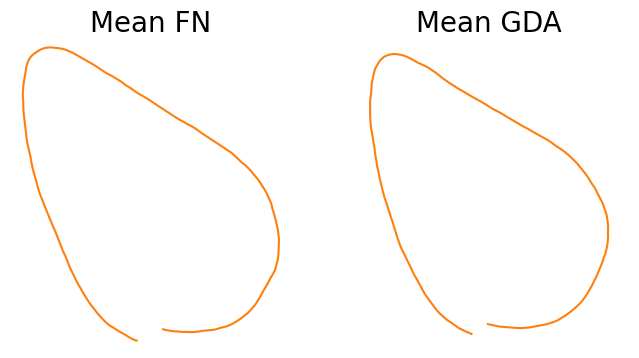

In [64]:
fig = plt.figure(figsize=(8, 4))
count = 1
for surface in SURFACES:
    mean_cell = mean_surface_cells[surface]
    fig.add_subplot(1, len(SURFACES), count)
    count += 1
    plt.plot(mean_cell[:, 0], mean_cell[:, 1], color=f"C1")
    plt.axis("equal")
    plt.axis("off")
    plt.title(f"Mean {surface}", fontsize=20)
# plt.savefig("cancer_mean_line_cells.svg")

In [65]:
mean_cells = {}
for mutation in MUTATIONS:
    mean_cells[mutation] = {}
    for surface in SURFACES:
        mean_estimator = FrechetMean(space=CURVES_SPACE_SRV)
        mean_estimator.fit(gs.array(ds_align[mutation][surface][:20]))
        mean_cells[mutation][surface] = mean_estimator.estimate_

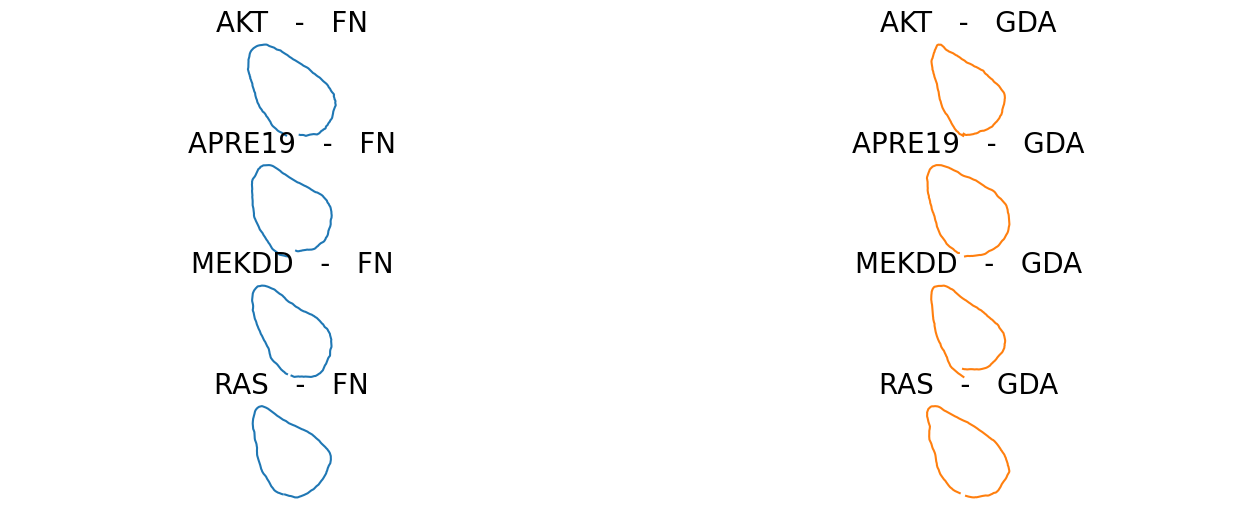

In [66]:
fig = plt.figure(figsize=(16, 6))
count = 1
for mutation in MUTATIONS:
    for j, surface in enumerate(SURFACES):
        mean_cell = mean_cells[mutation][surface]
        fig.add_subplot(len(MUTATIONS), len(SURFACES), count)
        count += 1
        plt.plot(mean_cell[:, 0], mean_cell[:, 1], color=f"C{j}")
        plt.axis("equal")
        plt.axis("off")
        plt.title(f"{mutation}   -   {surface}", fontsize=20)
# plt.savefig("cancer_mean_cells.svg")

# Rewrite this
While the mean shapes of the control groups (for both cell surfaces) look regular, we observe that:
- the mean shape for cytd is the most irregular (for both cell surfaces)
- while the mean shape for jasp is more elongated for dlm8 cell line, and more irregular for dunn cell line.

# Distance of the Cell Shapes to their Own Mean Shape

Lastly, we evaluate how each subgroup of cell shapes is distributed around the mean shape of their specific subgroup.

In [67]:
dists_to_own_mean = {}
nan_ids = {}
for mutation in MUTATIONS:
    dists_to_own_mean[mutation] = {}
    nan_ids[mutation] = {}
    for surface in SURFACES:
        dists = []
        ids = []
        for i_curve, curve in enumerate(ds_align[mutation][surface]):
            one_dist = CURVES_SPACE_SRV.metric.dist(curve, mean_cells[mutation][surface])
            if ~gs.isnan(one_dist):
                dists.append(one_dist)
            else:
                ids.append(i_curve)
        dists_to_own_mean[mutation][surface] = dists
        nan_ids[mutation][surface] = ids

Text(0.5, 0.98, 'Histograms of elastic distances to *own* mean cell')

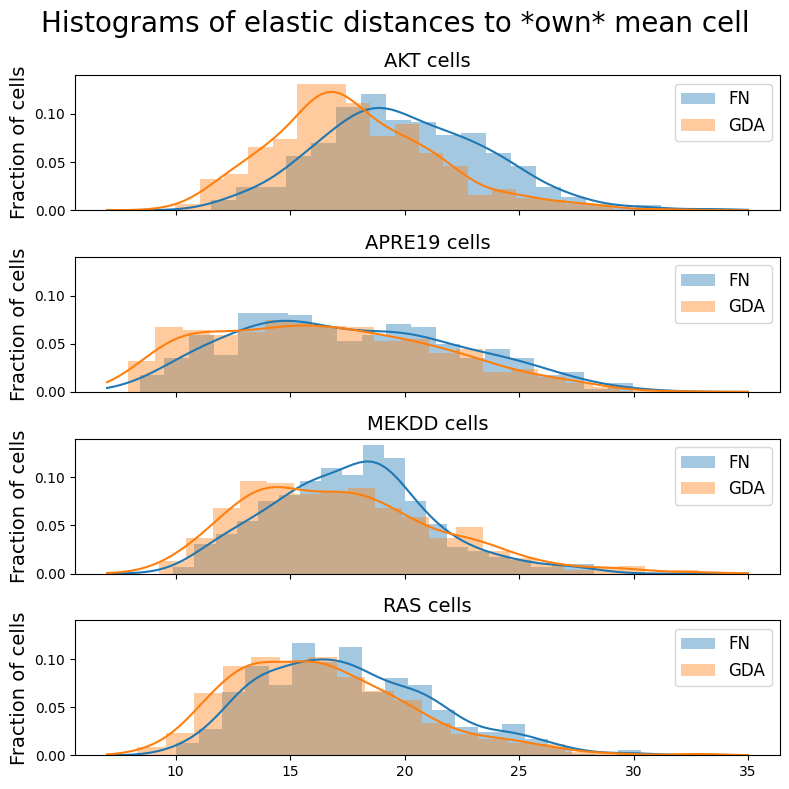

In [68]:
fig, axs = plt.subplots(4, sharex=True, sharey=True, tight_layout=True, figsize=(8, 8))

for i, mutation in enumerate(MUTATIONS):
    for j, surface in enumerate(SURFACES):
        distances = dists_to_own_mean[mutation][surface]
        color = f"C{j}"
        axs[i].hist(
            distances, bins=20, alpha=0.4, density=True, color=color, label=surface
        )
        kde = stats.gaussian_kde(distances)
        axs[i].plot(xx, kde(xx), color=color)

    axs[i].set_title(f"{mutation} cells", fontsize=14)
    axs[i].set_ylabel("Fraction of cells", fontsize=14)
    axs[i].legend(fontsize=12)

fig.suptitle("Histograms of elastic distances to *own* mean cell", fontsize=20)
# plt.savefig("dist_to_own_mean.svg")

# Rewrite this
Qualitatively, it seems that the control cells and the cells treated with cytd show the most variability in shape. The distributions of distances are more peaked for the cells treated with jasp, which indicates a lower variability in shape. We can hypothesize that the mutation jasp has an effect on the cell's cytoskeleton, in that it will constrain it, closer to its subgroup's mean shape.

Text(0.5, -0.01, 'Quantiles for SRV metric (a=1, b=0.5) using own mean')

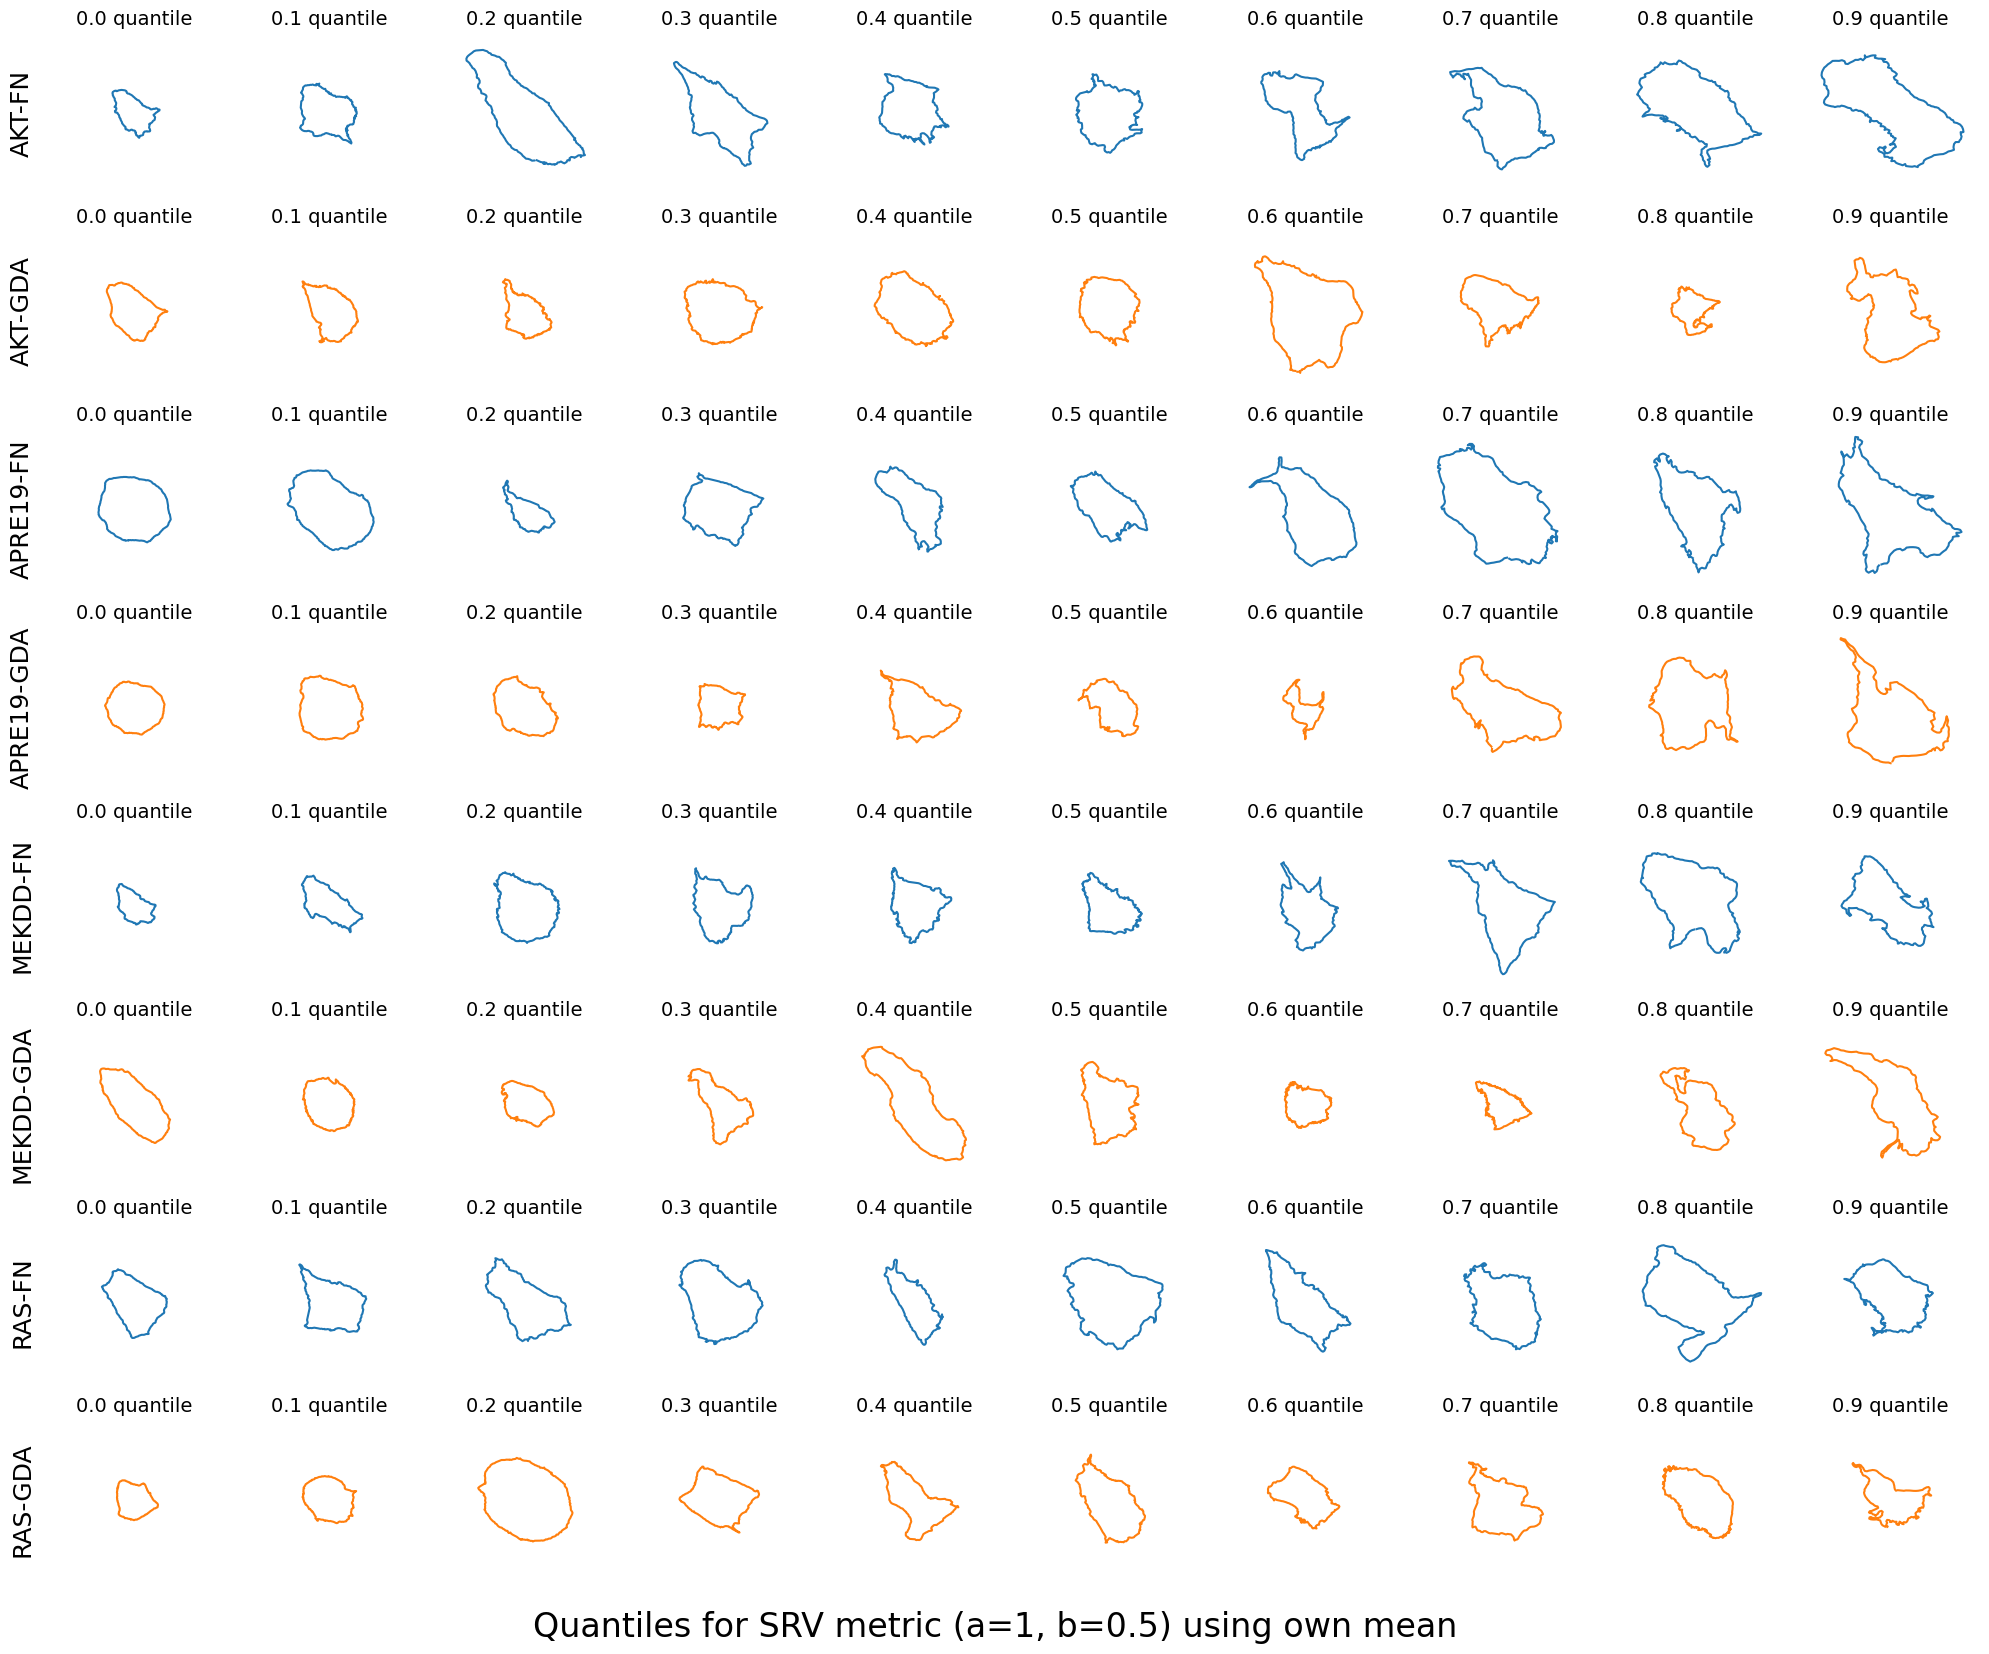

In [75]:
n_quantiles = 10
fig, axes = plt.subplots(
    nrows=len(MUTATIONS) * len(SURFACES),
    ncols=n_quantiles,
    figsize=(20, 2 * len(SURFACES) * len(MUTATIONS)),
)

for i, mutation in enumerate(MUTATIONS):
    for j, surface in enumerate(SURFACES):
        dists_list = dists_to_own_mean[mutation][surface]
        dists_list = [d + 0.0001 * gs.random.rand(1)[0] for d in dists_list]
        cells_list = list(ds_align[mutation][surface])
        assert len(dists_list) == len(dists_list)
        n_cells = len(dists_list)

        zipped_lists = zip(dists_list, cells_list)
        sorted_pairs = sorted(zipped_lists)

        tuples = zip(*sorted_pairs)
        sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
        for i_quantile in range(n_quantiles):
            quantile = int(0.1 * n_cells * i_quantile)
            one_cell = sorted_cells_list[quantile]
            ax = axes[2 * i + j, i_quantile]
            ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{j}")
            ax.set_title(f"0.{i_quantile} quantile", fontsize=14)
            ax.set_xlim(-170, 170)
            ax.set_ylim(-170, 170)
            # ax.axis("off")
            # Turn off tick labels
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_visible(False)
            ax.spines["left"].set_visible(False)
            if i_quantile == 0:
                ax.set_ylabel(f"{mutation}-{surface}", rotation=90, fontsize=18)
plt.tight_layout()
plt.suptitle(f"Quantiles for SRV metric (a=1, b=0.5) using own mean", y=-0.01, fontsize=24)
# plt.savefig("quantiles.svg")

The above code find a given number of quantiles within the distance's histogram, using SRV metric and own mean, and plots the corresponding cell, for each mutation and each surface.

In [70]:
linear_dists_to_own_mean = {}
nan_ids = {}
for mutation in MUTATIONS:
    linear_dists_to_own_mean[mutation] = {}
    nan_ids[mutation] = {}
    for surface in SURFACES:
        dists = []
        ids = []
        for i_curve, curve in enumerate(ds_align[mutation][surface]):
            one_dist = gs.linalg.norm(curve-mean_cells[mutation][surface])
            # gs.linalg.norm(linear_mean_estimate - x) 
            if ~gs.isnan(one_dist):
                dists.append(one_dist)
            else:
                ids.append(i_curve)
        linear_dists_to_own_mean[mutation][surface]= dists
        nan_ids[mutation][surface]= ids

Text(0.5, -0.01, 'Quantiles for linear metric (a=1, b=0.5) using own mean')

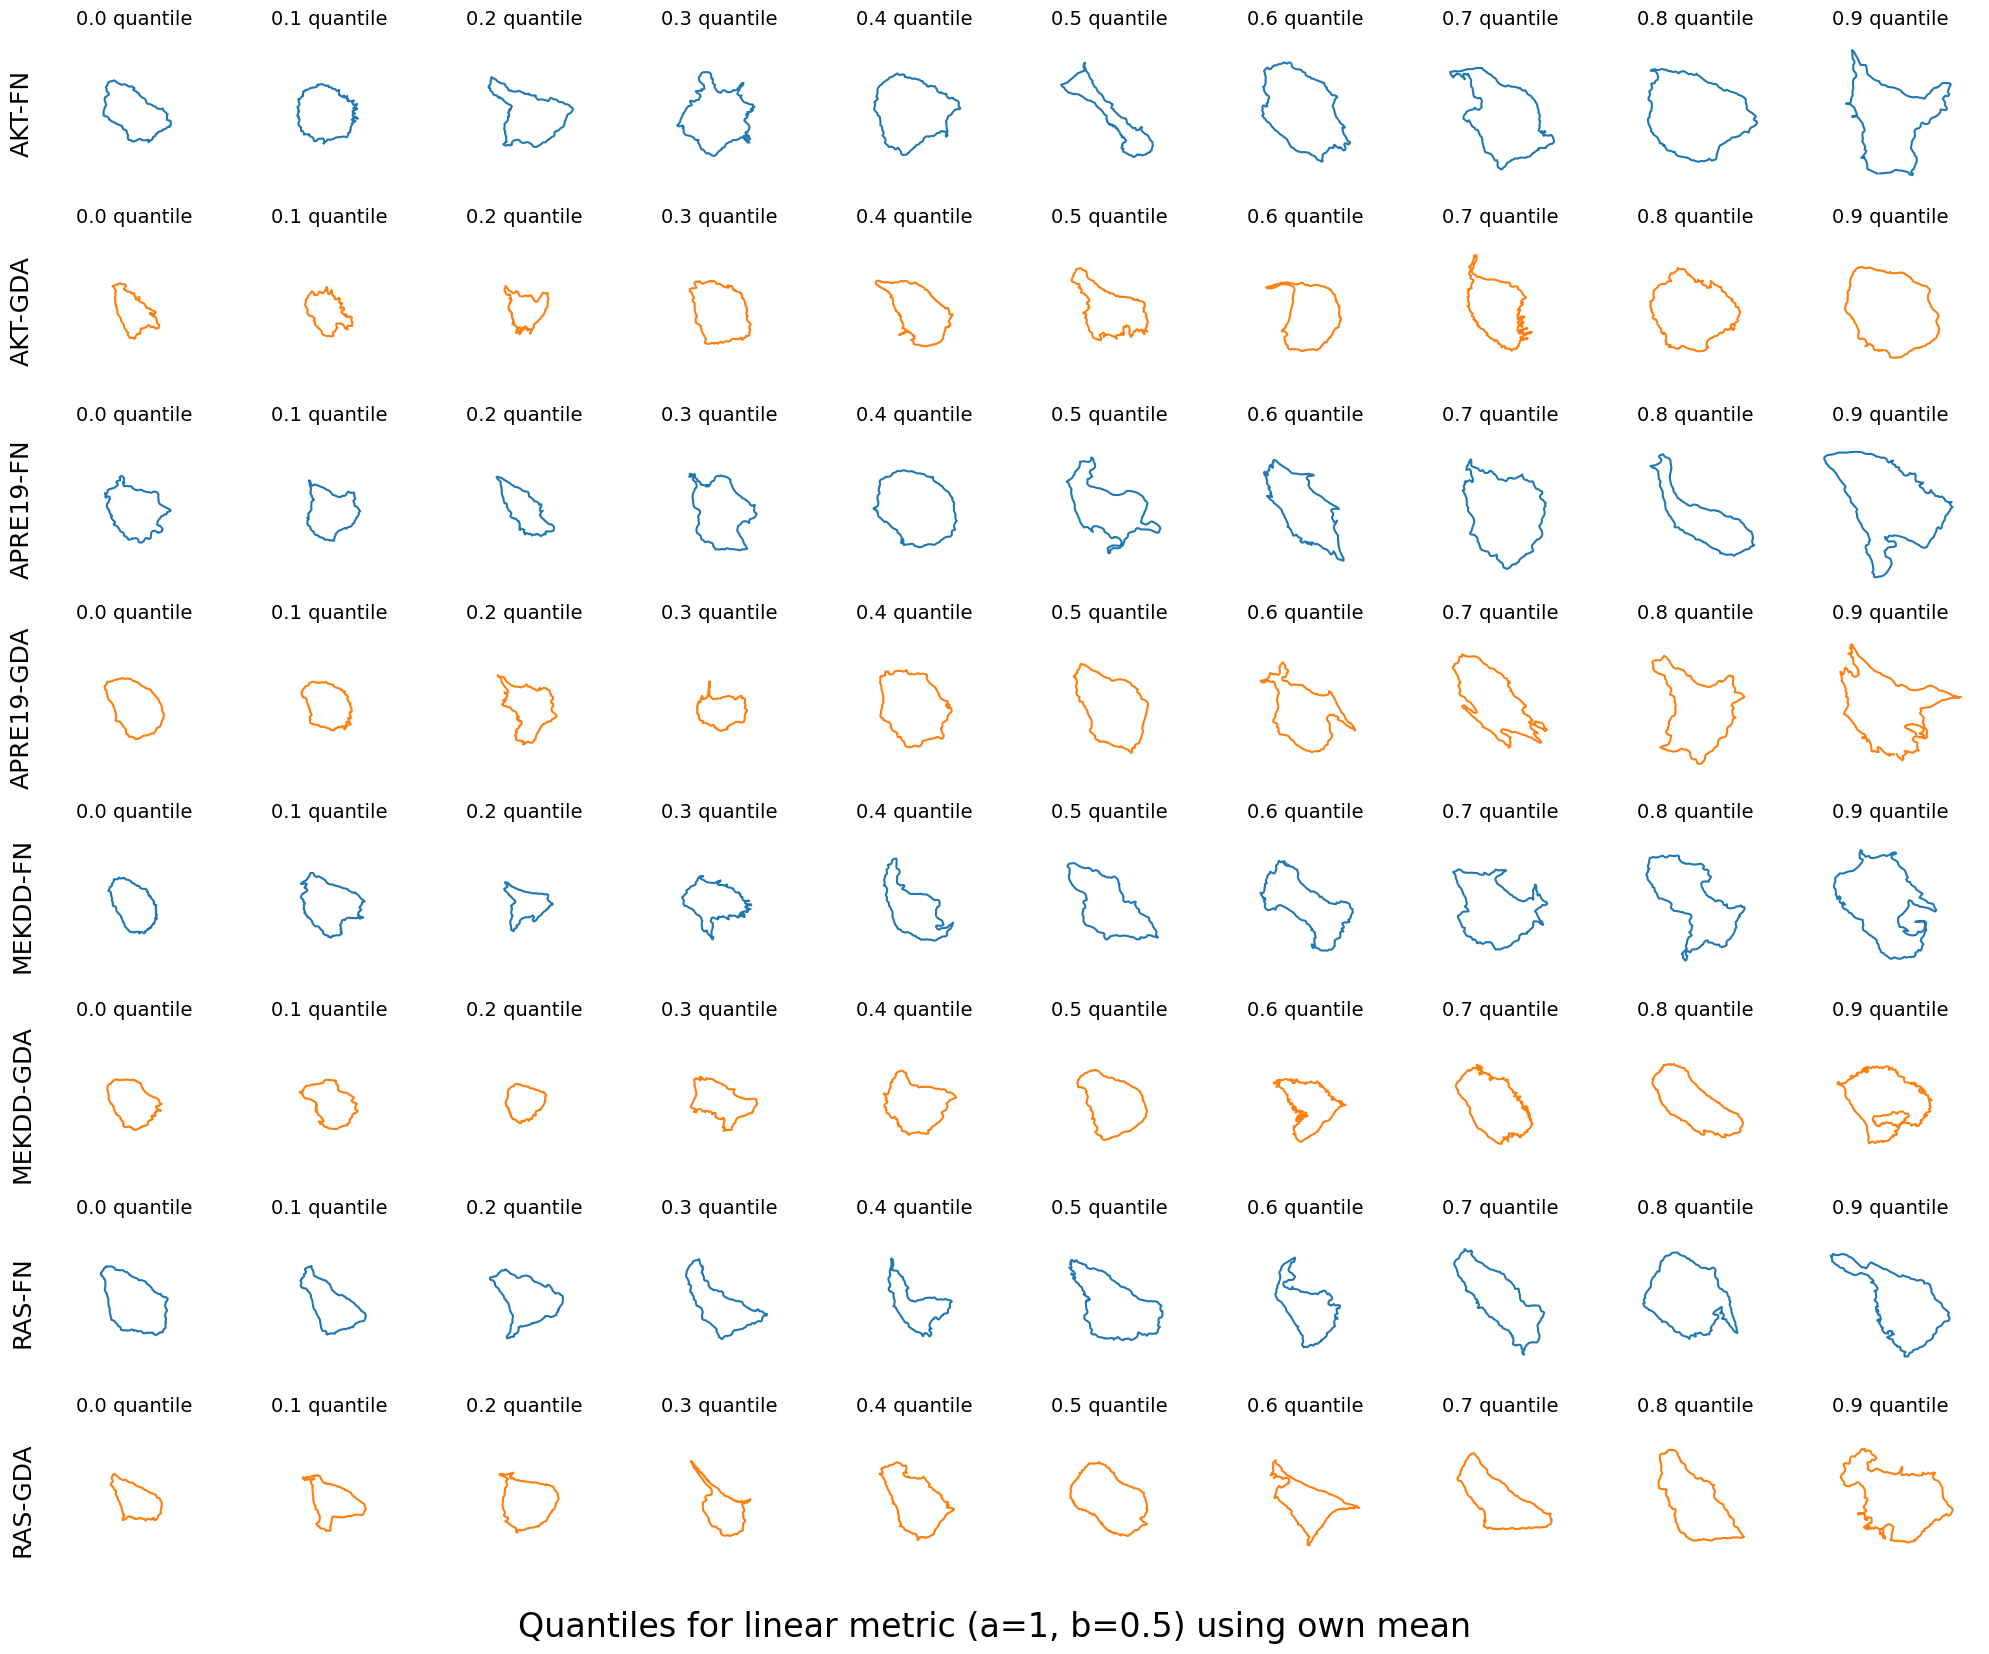

In [72]:
n_quantiles = 10
fig, axes = plt.subplots(
    nrows=len(MUTATIONS) * len(SURFACES),
    ncols=n_quantiles,
    figsize=(20, 2 * len(SURFACES) * len(MUTATIONS)),
)


for i, mutation in enumerate(MUTATIONS):
    for j, surface in enumerate(SURFACES):
        dists_list = linear_dists_to_own_mean[mutation][surface]
        dists_list = [d + 0.0001 * gs.random.rand(1)[0] for d in dists_list]
        cells_list = list(ds_align[mutation][surface])
        assert len(dists_list) == len(dists_list)
        n_cells = len(dists_list)

        zipped_lists = zip(dists_list, cells_list)
        sorted_pairs = sorted(zipped_lists)

        tuples = zip(*sorted_pairs)
        sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
        for i_quantile in range(n_quantiles):
            quantile = int(0.1 * n_cells * i_quantile)
            one_cell = sorted_cells_list[quantile]
            ax = axes[2 * i + j, i_quantile]
            ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{j}")
            ax.set_title(f"0.{i_quantile} quantile", fontsize=14)
            ax.set_xlim(-170, 170)
            ax.set_ylim(-170, 170)
            # ax.axis("off")
            # Turn off tick labels
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_visible(False)
            ax.spines["left"].set_visible(False)
            if i_quantile == 0:
                ax.set_ylabel(f"{mutation}-{surface}", rotation=90, fontsize=18)
plt.tight_layout()
plt.suptitle(f"Quantiles for linear metric (a=1, b=0.5) using own mean", y=-0.01, fontsize=24)
# plt.savefig("quantiles.svg")

The above code find a given number of quantiles within the distance's histogram, using linear metric and own mean, and plots the corresponding cell, for each mutation and each surface.

# Dimensionality Reduction

We use the following experiments to illustrate how SRV metric can help with dimensionality reduction 

In [76]:
from numba import jit, njit, prange

def srv_dist(cell1, cell2):
    return CURVES_SPACE_SRV.metric.dist(cell1, cell2) / k_sampling_points
 
@jit(nopython=False, forceobj=True)
def parallel_dist(cells, dist_fun):
    pairwise_dists = np.zeros((cells.shape[0], cells.shape[0]))
    for i in prange(cells.shape[0]):
        for j in prange(i + 1, cells.shape[0]):
            pairwise_dists[i, j] = dist_fun(cells[i], cells[j]) / k_sampling_points
    pairwise_dists += pairwise_dists.T
    return pairwise_dists

In [77]:
# pairwise_srv_dists = parallel_dist(cell_shapes, dist_fun=srv_dist)

INFO: finding looplift candidates


In [89]:
# # export pairwise_srv_dists
# pairwise_srv_dists.shape
# np.save(os.path.join(figs_dir, 'pairwise_srv_dists_wout_scale.npy'), pairwise_srv_dists)

pairwise_srv_dists = np.load(os.path.join(figs_dir, 'pairwise_srv_dists_wout_scale.npy'))

Calculate MDS statistics for dimension 2

In [90]:
from sklearn import manifold


mds = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos = mds.fit(pairwise_srv_dists).embedding_
print("the stress for SRV model is:", mds.stress_)
print(pairwise_srv_dists.shape)
print(pos.shape)

/home/wanxinli/.local/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


the stress for SRV model is: 0.39441794672822006
(3868, 3868)
(3868, 2)


MDS embedding of cell mutations for different cell surfaces

In [91]:
embs = {}
index = 0
for mutation in MUTATIONS:
    embs[mutation] = {}
    for surface in SURFACES:
        cell_num = len(ds_align[mutation][surface])   
        embs[mutation][surface]= pos[index:index+cell_num]
        index += cell_num

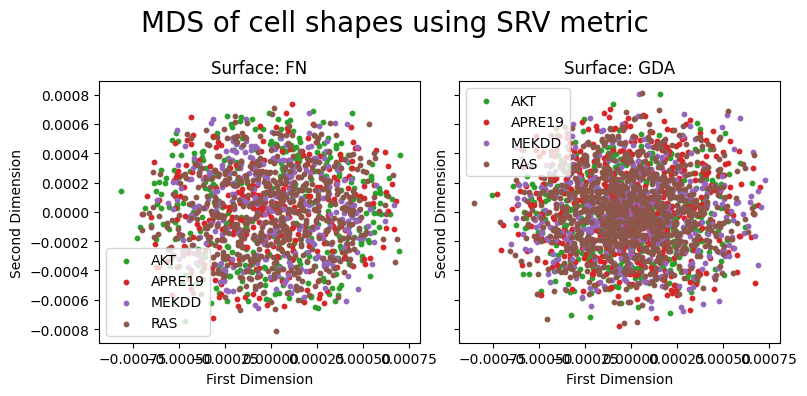

In [93]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, tight_layout=True, figsize=(8, 4))

for j, surface in enumerate(SURFACES):
    distances = []
    for i, mutation in enumerate(MUTATIONS):
        cur_embs = embs[mutation][surface]
        color = "C" + str(2 + i)
        axs[j].scatter(
                cur_embs[:, 0],
                cur_embs[:, 1],
                c=color,
                label=mutation,
                s=10
            )
        # axs[j].set_xlim(-0.02, 0.04)
        # axs[j].set_ylim(-0.02, 0.04)
        axs[j].set_xlabel("First Dimension")
        axs[j].set_ylabel("Second Dimension")
        axs[j].legend()
        axs[j].set_title(f"Surface: {surface}")
fig.suptitle("MDS of cell shapes using SRV metric", fontsize=20)

plt.tight_layout()

# plt.savefig("dist_to_global_mean_per_mutation2.svg")

We draw a comparison with linear metric using the following code

In [83]:
def linear_dist(cell1, cell2):
    return gs.linalg.norm(cell1 - cell2) / k_sampling_points

In [84]:
pairwise_linear_dists = parallel_dist(cell_shapes, dist_fun=linear_dist)

In [85]:
mds = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos = mds.fit(pairwise_linear_dists).embedding_
print("the stress for linear model is:", mds.stress_)


/home/wanxinli/.local/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


the stress for linear model is: 47.78917666949604


However, the stress for MDS embedding using the linear metric is better than SRV metric

In [86]:
embs = {}
index = 0
for mutation in MUTATIONS:
    embs[mutation] = {}
    for surface in SURFACES:
        cell_num = len(ds_align[mutation][surface])   
        embs[mutation][surface]= pos[index:index+cell_num]
        index += cell_num

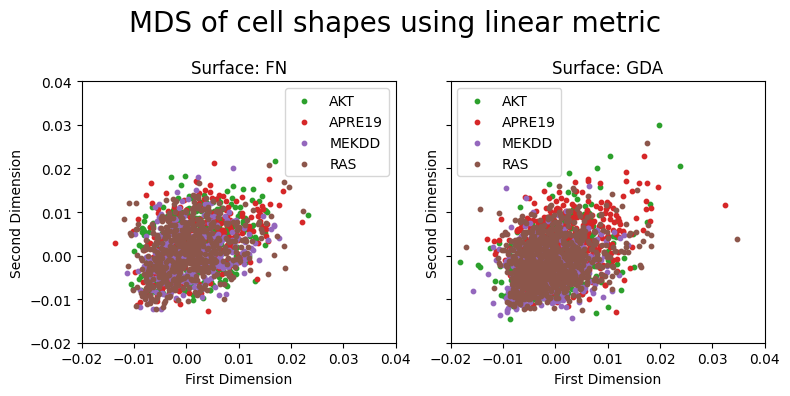

In [88]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, tight_layout=True, figsize=(8, 4))

for j, surface in enumerate(SURFACES):
    distances = []
    for i, mutation in enumerate(MUTATIONS):
        cur_embs = embs[mutation][surface]
        color = "C" + str(2 + i)
        axs[j].scatter(
                cur_embs[:, 0],
                cur_embs[:, 1],
                c=color,
                label=mutation,
                s=10
            )
        axs[j].set_xlim(-0.02, 0.04)
        axs[j].set_ylim(-0.02, 0.04)

        axs[j].set_xlabel("First Dimension")
        axs[j].set_ylabel("Second Dimension")
        axs[j].legend()
        axs[j].set_title(f"Surface: {surface}")
fig.suptitle("MDS of cell shapes using linear metric", fontsize=20)

plt.tight_layout()

# plt.savefig("dist_to_global_mean_per_mutation2.svg")